In [74]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime

import os
import pendulum
import scipy
import scikit_posthocs as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# Load Statsmodels 
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Load final data

In [76]:
df = pd.read_csv('data/df_final.csv')

In [77]:
df.head()

,dates,geography_key,wholesaler_id_value,state_code,city,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday,product_price,relative_beer_style_price,Era,brewer
0,2018-12-23,39774,3142,NY,JAMESTOWN,RITE AID - RITE AID PHARMACY,DRUG,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,15.00,29.85,1.30,2018,12,23,51,winter,0,1.99,0.98,Pre Covid,AB
1,2018-12-23,39774,3142,NY,JAMESTOWN,RITE AID - RITE AID PHARMACY,DRUG,210281267,EASY DRINKING,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,36.00,71.64,3.10,2018,12,23,51,winter,0,1.99,0.98,Pre Covid,AB
2,2018-12-23,5446689,43100,NY,STATEN ISLAND,7 ELEVEN - SPEEDWAY SUPERAMERICA,CONVENIENCE,210283096,CLASSIC LAGER,VALUE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,296.00,298.32,25.70,2018,12,23,51,winter,0,1.01,0.49,Pre Covid,AB
3,2018-12-23,627036,3142,NY,JAMESTOWN,7-ELEVEN - 7 ELEVEN/NORTH ATLANTIC DIV,CONVENIENCE,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,35.00,71.21,3.00,2018,12,23,51,winter,0,2.03,1.00,Pre Covid,AB
4,2018-12-23,147449,43100,NY,NEW YORK,KMART - K MART,MASS MERCHANDISER,210283096,CLASSIC LAGER,VALUE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,85.00,126.65,7.40,2018,12,23,51,winter,0,1.49,0.73,Pre Covid,AB


## Explore data

In [78]:
df.shape

(16357, 26)

In [79]:
# Data types of the columns

df.dtypes

dates                         object
geography_key                  int64
wholesaler_id_value            int64
state_code                    object
city                          object
retailer_name                 object
outlet_name                   object
product_key                    int64
ab_category_style_value       object
ab_wamp_value                 object
beer_style_value              object
brewer_value                  object
type_value                    object
unit_sales                   float64
dollar_sales                 float64
volume_sales                 float64
year                           int64
month                          int64
day                            int64
week                           int64
season                        object
holiday                        int64
product_price                float64
relative_beer_style_price    float64
Era                           object
brewer                        object
dtype: object

In [80]:
# conver the date col to datetime
df['dates'] = pd.to_datetime(df['dates'])

df.dtypes

dates                        datetime64[ns]
geography_key                         int64
wholesaler_id_value                   int64
state_code                           object
city                                 object
retailer_name                        object
outlet_name                          object
product_key                           int64
ab_category_style_value              object
ab_wamp_value                        object
beer_style_value                     object
brewer_value                         object
type_value                           object
unit_sales                          float64
dollar_sales                        float64
volume_sales                        float64
year                                  int64
month                                 int64
day                                   int64
week                                  int64
season                               object
holiday                               int64
product_price                   

In [81]:
unique_wholesalers = list(df.wholesaler_id_value.unique())
unique_products = list(df.product_key.unique())

## Find wholesaler, product pairs that have less than a year worth of sales - we will ensure to not include them in our forecasting model.

In [82]:
no_sales_list = []

for w in unique_wholesalers:
    for p in unique_products:
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        if df_small.shape[0]<53:
            no_sales_list.append((w, p))
            print(f'For wholesaler {w} & product {p} time series, there are {df_small.shape[0]} weeks in the data')

For wholesaler 43100 & product 262793636 time series, there are 0 weeks in the data
For wholesaler 43100 & product 609521221 time series, there are 0 weeks in the data
For wholesaler 43100 & product 1321133691 time series, there are 25 weeks in the data
For wholesaler 43168 & product 210280222 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210281267 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210283096 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210284670 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210281273 time series, there are 0 weeks in the data
For wholesaler 83167 & product 210283096 time series, there are 36 weeks in the data
For wholesaler 34206 & product 210283096 time series, there are 0 weeks in the data
For wholesaler 34206 & product 210281273 time series, there are 0 weeks in the data
For wholesaler 44223 & product 210283096 time series, there are 1 weeks i

## Statistical test to check stationarity in time series 

**We will experiment with `Augmented Dickey-Fuller (ADF)`**

**Null Hypothesis (HO): Series is non-stationary.**

**Alternate Hypothesis(HA): Series is stationary.**

In [37]:
# Changing the YEAR data type and setting it as index
df_copy = df.copy()
df_copy.index = df_copy['dates']

del df_copy['dates']

# ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

for w in unique_wholesalers:
    for p in unique_products:
        if (w, p) not in no_sales_list:
            
            print(f'Seasonality check for wholesaler {w} & product {p}')
            # Run test
            adf_test(df_copy['unit_sales'])


Seasonality check for wholesaler 3142 & product 210280222
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64
Seasonality check for wholesaler 3142 & product 210281267
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64
Seasonality check for wholesaler 3142 & product 210283096
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations 

Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64
Seasonality check for wholesaler 83167 & product 210281267
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64
Seasonality check for wholesaler 83167 & product 210284670
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)           

Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64
Seasonality check for wholesaler 44223 & product 1321133691
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64
Seasonality check for wholesaler 44276 & product 210280222
Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)          

**The p-value is significant and hence, we can reject the null hypothesis and, declare that the time series is infact stationary which is an assumption for the time series models.**

## Run statistical tests to understand impact of features on demand

**Run ANOVA, Kruskal-Wallis and post hoc tests for the categorical features to understand if the group means are statistically significant.**

In [221]:
anova_args = tuple(df.groupby('beer_style_value')['unit_sales'].apply(list).reset_index()['unit_sales'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)

print(f_statistic, p_value)

600.1916825776608 0.0


In [222]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['unit_sales'], groups=df['beer_style_value'], alpha=0.05)
print(m_comp)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
    group1            group2         meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------------
AMERICAN LAGER                  IPA  -93.2781  0.001  -105.802  -80.7542   True
AMERICAN LAGER          MALT LIQUOR   82.6907  0.001    70.366   95.0154   True
AMERICAN LAGER       TROPICAL LAGER  -82.8779  0.001  -91.8377  -73.9181   True
AMERICAN LAGER VARIETY PACK/SAMPLER  -88.4446  0.001   -95.599  -81.2902   True
           IPA          MALT LIQUOR  175.9688  0.001  159.7559  192.1818   True
           IPA       TROPICAL LAGER   10.4002 0.2414   -3.4288   24.2292  False
           IPA VARIETY PACK/SAMPLER    4.8336 0.8177   -7.9001   17.5673  False
   MALT LIQUOR       TROPICAL LAGER -165.5686  0.001 -179.2174 -151.9198   True
   MALT LIQUOR VARIETY PACK/SAMPLER -171.1353  0.001 -183.6731 -158.5975   True
TROPICAL LAGER VARIETY PACK/SAMPLER   -5

**Running the ANOVA test on the beer style column to understand if the each of the beer styles in our sample data mean demand is statistically different from each other. And with a small p-value, it does seem like that is the case.** 

**Running a pairwise post hoc test to understand the differences in pairs of the groups in beer styles - looks like except (TROPICAL LAGER, VARIETY PACK/SAMPLER), (IPA, VARIETY PACK/SAMPLER) & (IPA, TROPICAL LAGER) - all the other pairs seem to have statistically significantly different group means.**

In [223]:
kruskal_args = tuple(df.groupby('holiday')['unit_sales'].apply(list).reset_index()['unit_sales'])
h_statistic, p_value = scipy.stats.kruskal(*kruskal_args)
print(p_value)

0.8123813128063446


In [224]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['unit_sales'], groups=df['holiday'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   -2.398 0.4194 -8.2186 3.4227  False
---------------------------------------------------


**Running the Kruskal-wallis test on the holiday column to understand if the two categories of whether or not the week is a holiday week, have their difference in mean demand statistically significant from each other. And with a high p-value, it doesn't seem like that is the case.** 

## Fill in missing data in individual time series where a wholesaler did not have any sales for the products in certain weeks

- `Assumption - All wholesalers get all of the chosen 10 products but there could be few wholesalers with less sales for certain products. We will remove time series where a wholesaler did not sell a particular product even for a single year out of the 5 year period.`

In [83]:
df_clean = df.drop(['year', 'month', 'day', 'week', 'season', 'holiday'], axis=1)

In [84]:
df_filled_missing_list = []

for w in unique_wholesalers:
    for p in unique_products:
        
        if (w, p) not in no_sales_list:
            df_small = df_clean[(df_clean['wholesaler_id_value']== w) & (df_clean['product_key']== p)]

            new_df = pd.DataFrame()
            new_df['revised_dates'] = pd.date_range(start='2018-01-07', end='2023-01-15', freq='W')

            new_df['wholesaler_id_value'] = w
            new_df['product_key'] = p

            df_small = df_small[['dates'] + 
                                [col for col in df_clean.columns if df_clean[f'{col}'].dtypes == 'float64' 
                                                                 or df_clean[f'{col}'].dtypes == 'int64'
                                                                
                                ]]

            new_df = new_df.merge(df_small, how='left', left_on='revised_dates', right_on='dates')
            
            new_df.drop(['wholesaler_id_value_y', 'product_key_y', 'geography_key'], axis=1, inplace=True)
            new_df.rename(columns={'wholesaler_id_value_x': 'wholesaler_id_value', 
                                   'product_key_x': 'product_key'}, inplace=True)

            df_filled_missing_list.append(new_df)
        
df_filled_missing = pd.concat(df_filled_missing_list)

for col in df.columns:
    if df[f'{col}'].dtypes == 'float64':
        df_filled_missing[f'{col}'] = df_filled_missing[f'{col}'].fillna(0)
        
df_filled_missing.isnull().sum()

revised_dates                   0
wholesaler_id_value             0
product_key                     0
dates                        3928
unit_sales                      0
dollar_sales                    0
volume_sales                    0
product_price                   0
relative_beer_style_price       0
dtype: int64

In [85]:
df_filled_missing.shape

(20188, 9)

In [86]:
df_filled_missing.head()

,revised_dates,wholesaler_id_value,product_key,dates,unit_sales,dollar_sales,volume_sales,product_price,relative_beer_style_price
0,2018-01-07,3142,210280222,2018-01-07,54.00,113.40,4.70,2.10,1.03
1,2018-01-07,3142,210280222,2018-01-07,9.00,17.91,0.80,1.99,0.98
2,2018-01-14,3142,210280222,2018-01-14,62.00,128.34,5.40,2.07,1.02
3,2018-01-14,3142,210280222,2018-01-14,2.00,3.98,0.20,1.99,0.98
4,2018-01-21,3142,210280222,2018-01-21,59.00,120.95,5.10,2.05,1.01


## Generate ACF and PACF plots

#### Few feature engineering approaches to experiment with - 

- **Lagged features for the target variable**
- **Rolling window feature.**

### For lagged features - plot ACF plots and PACF plots

- `ACF plots helps to understand the correlation between time series and the lagged version of itself.`
- `PACF plots helps to understand the correlation between the time series with a lagged version of itself but after    eliminating the variations already explained by the intervening comparisons.`

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



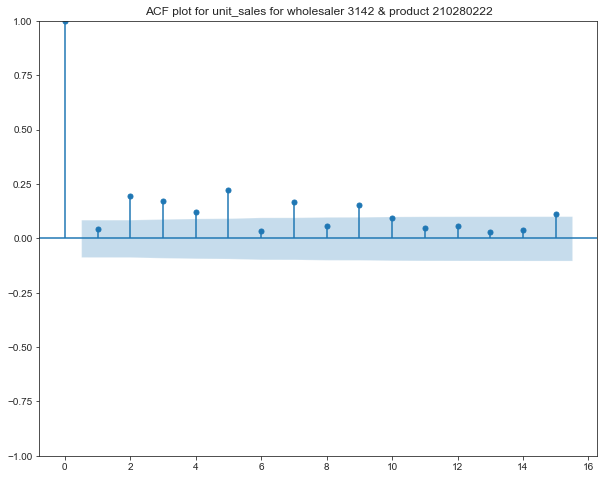

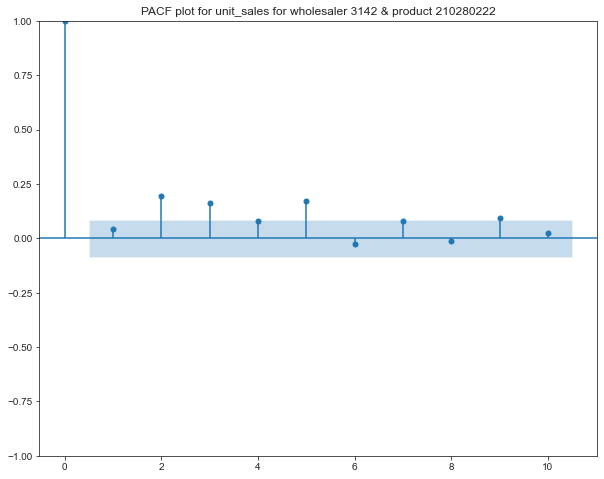

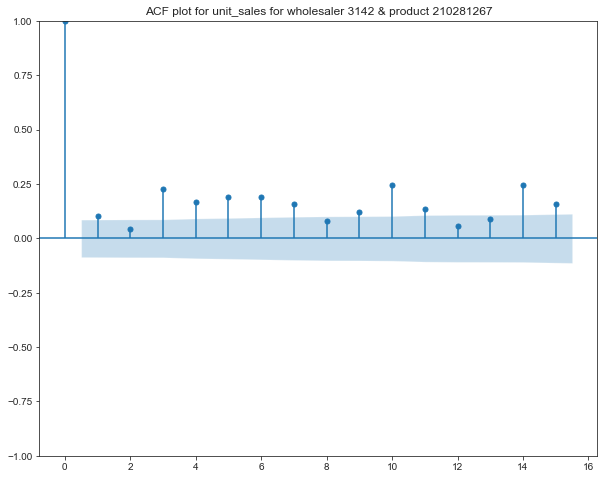

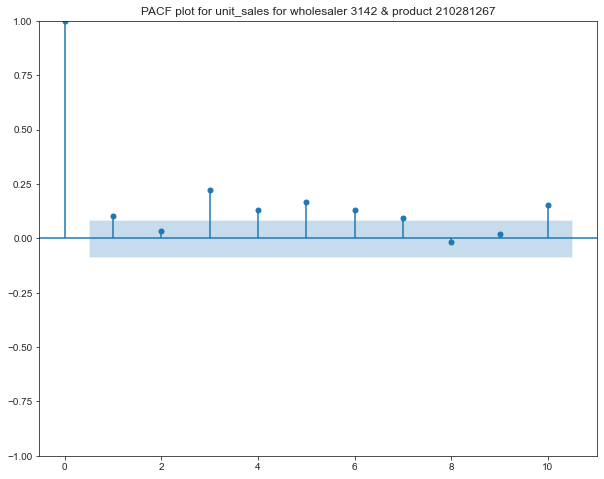

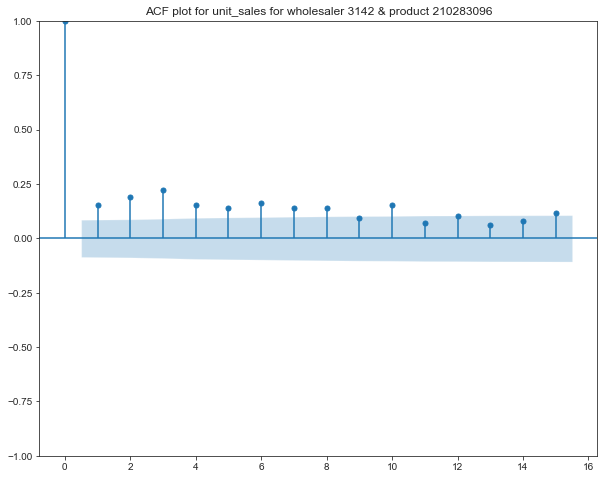

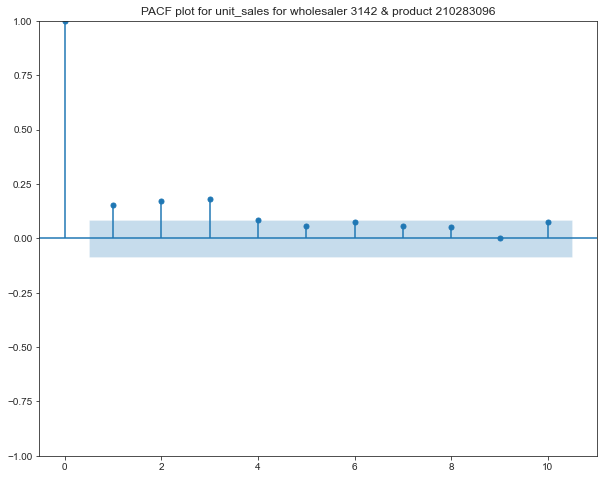

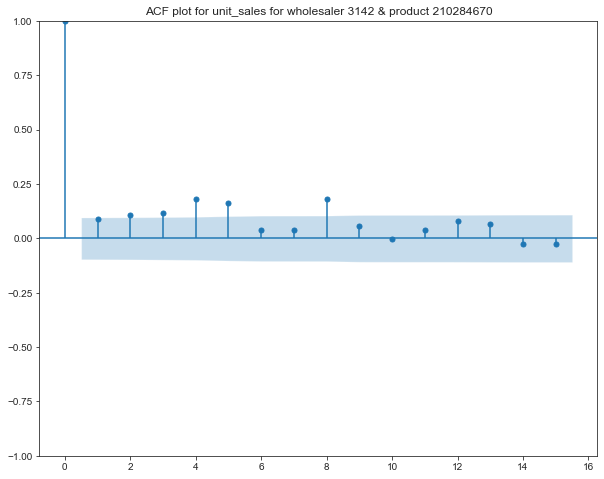

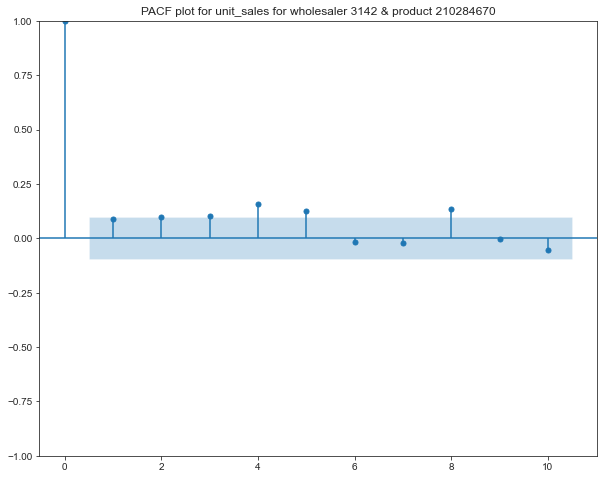

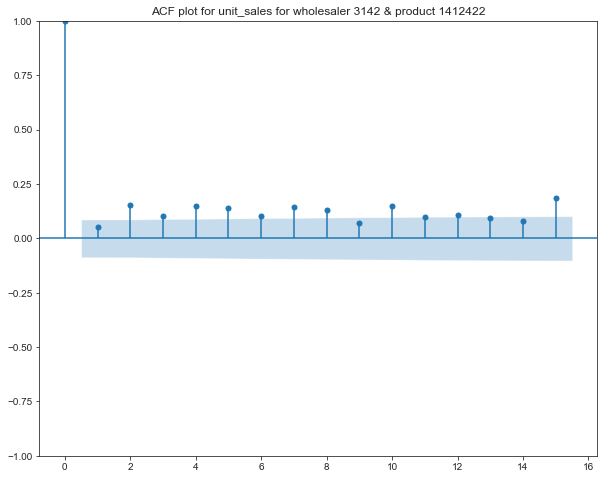

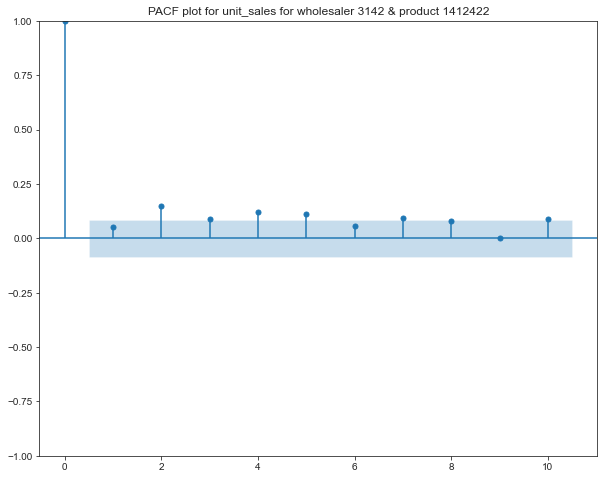

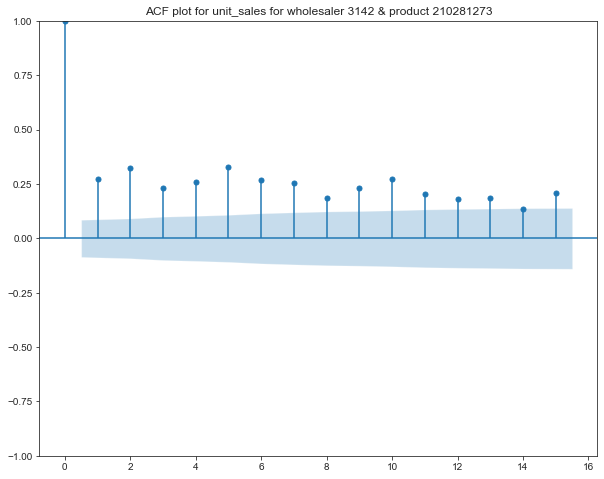

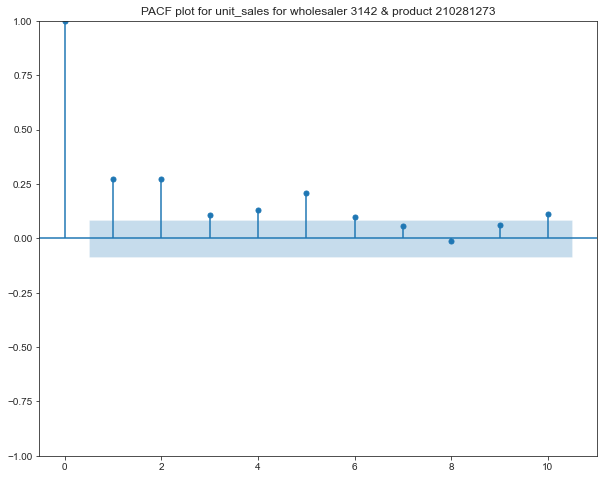

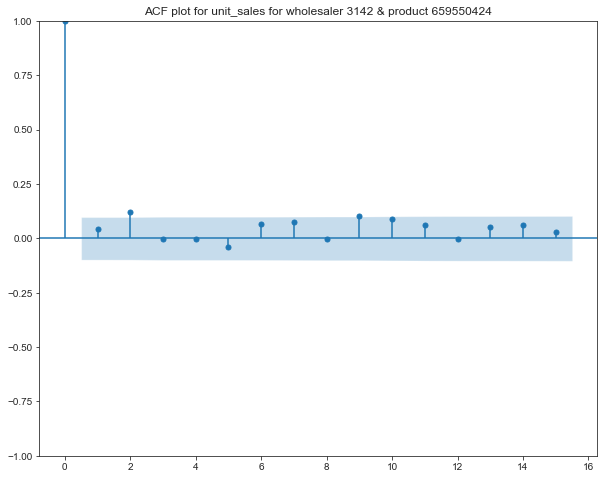

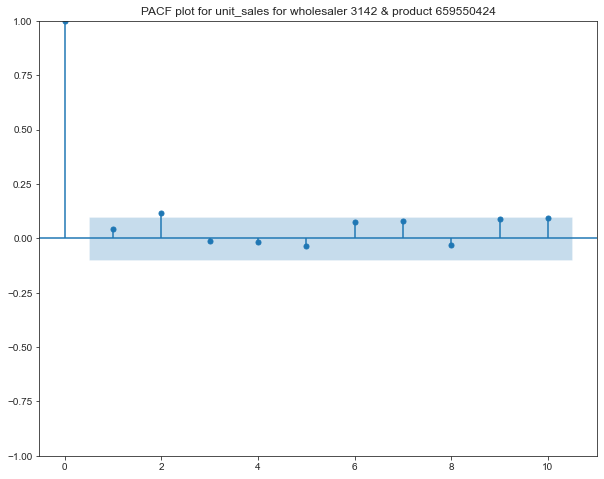

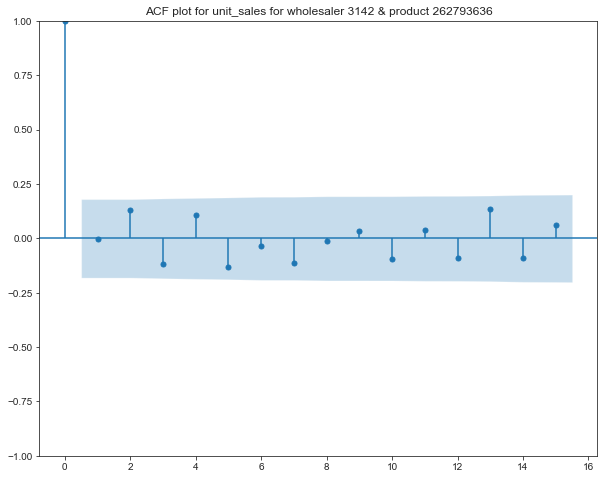

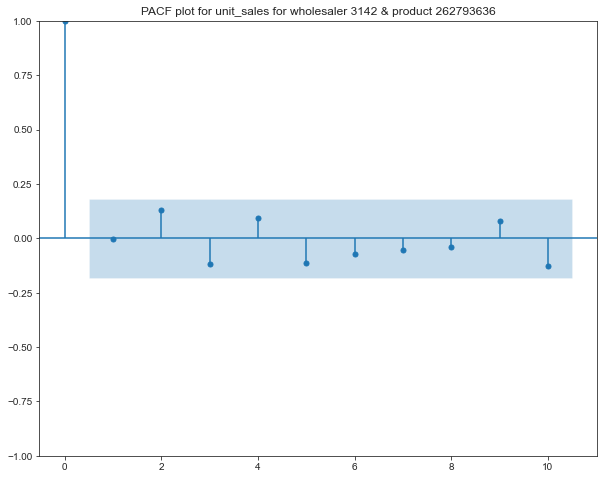

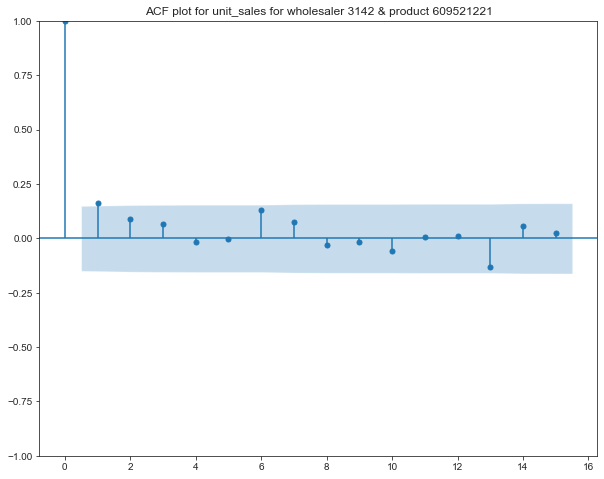

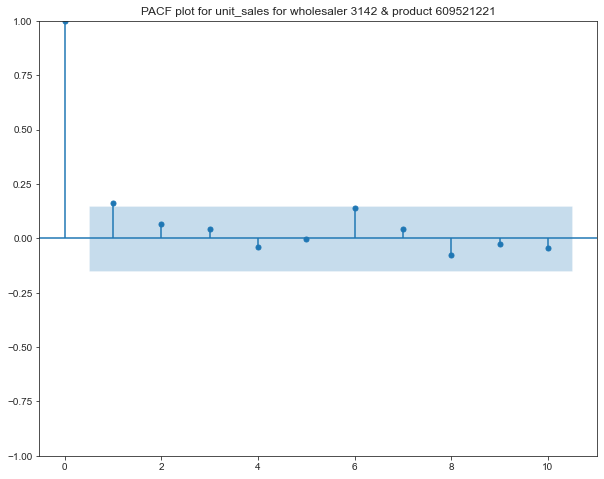

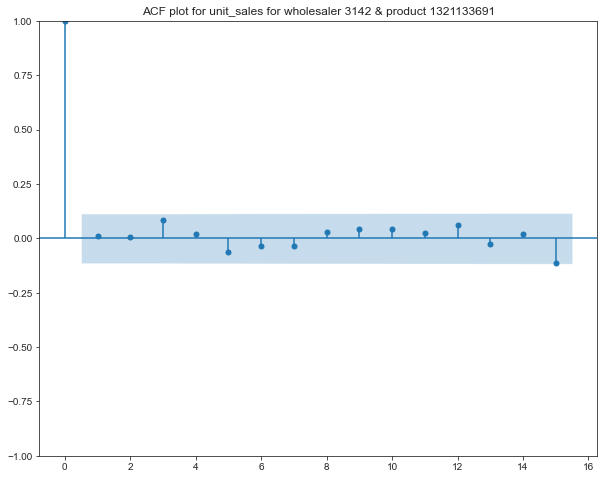

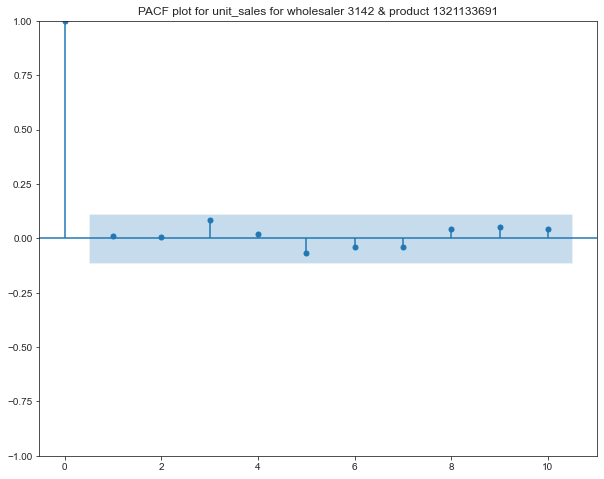

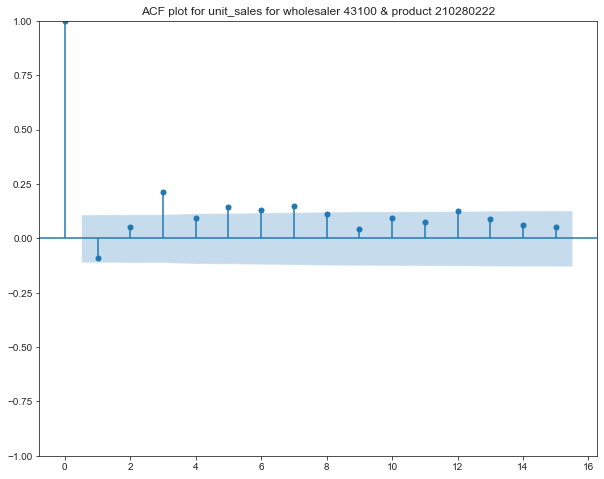

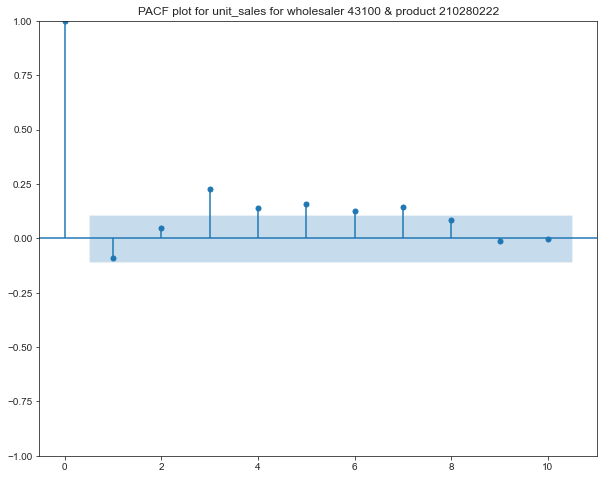

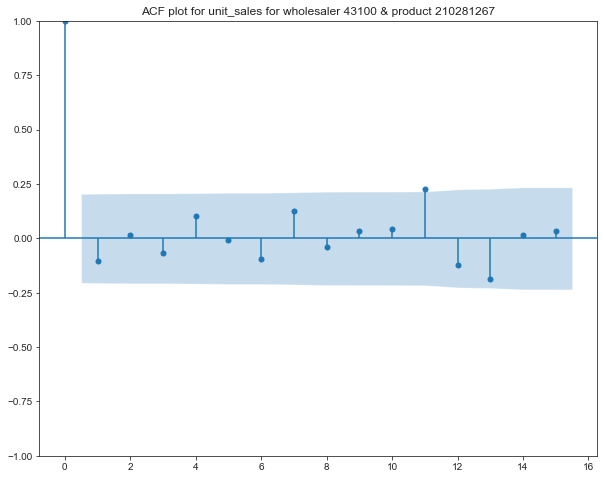

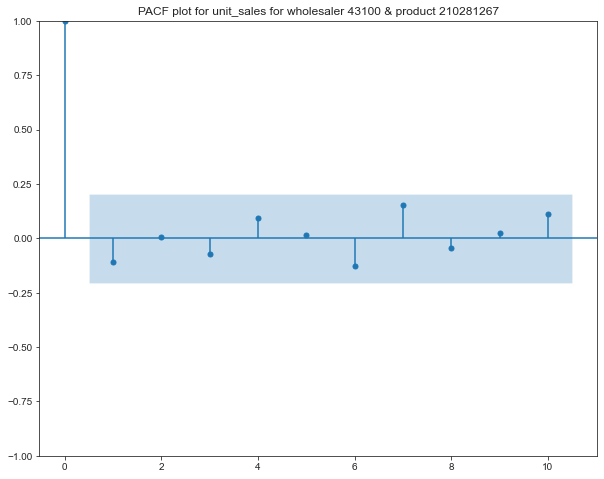

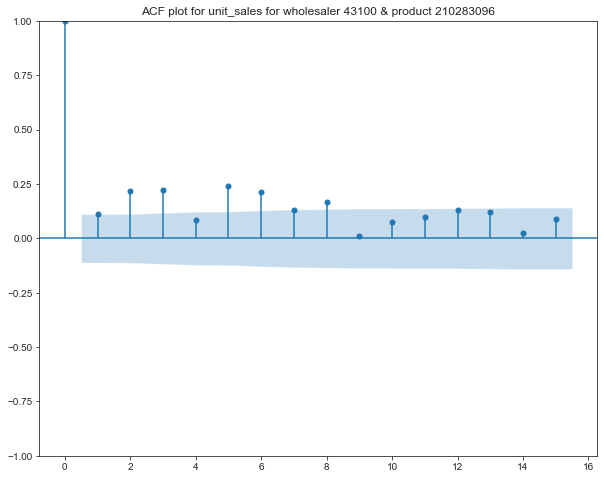

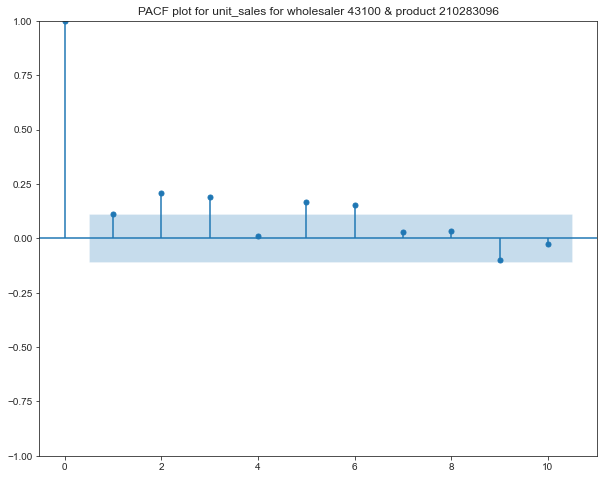

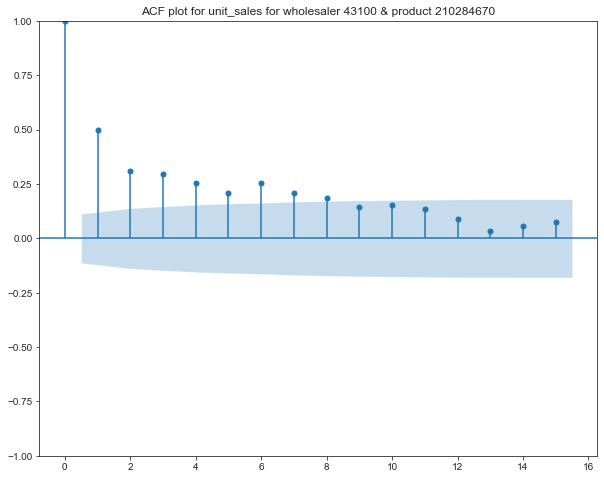

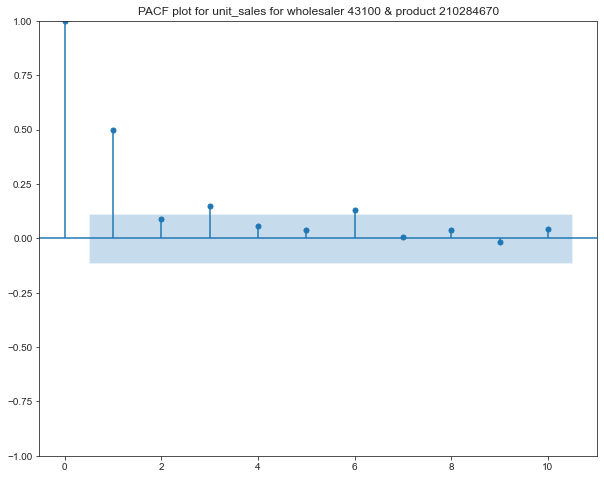

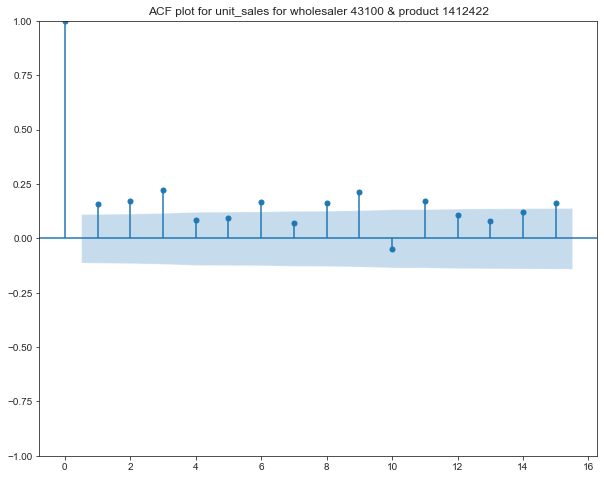

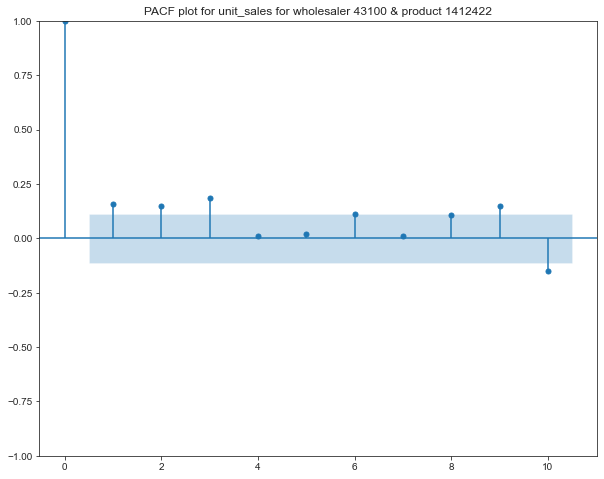

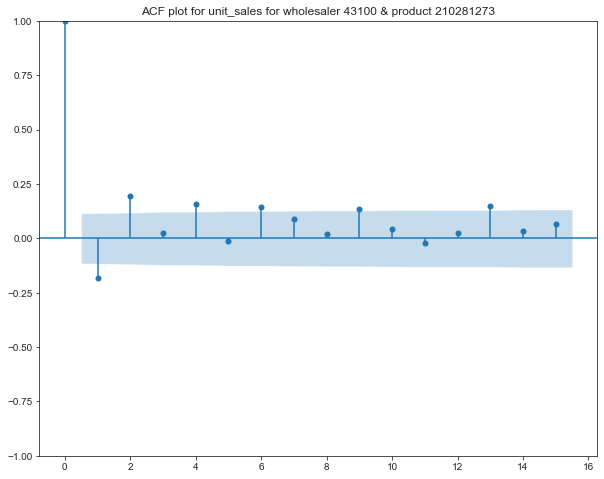

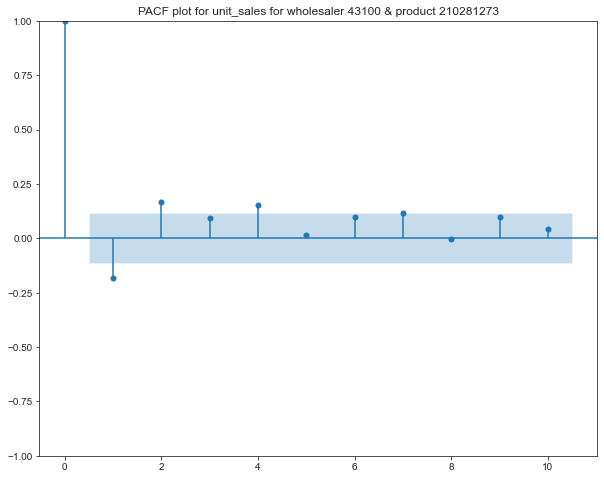

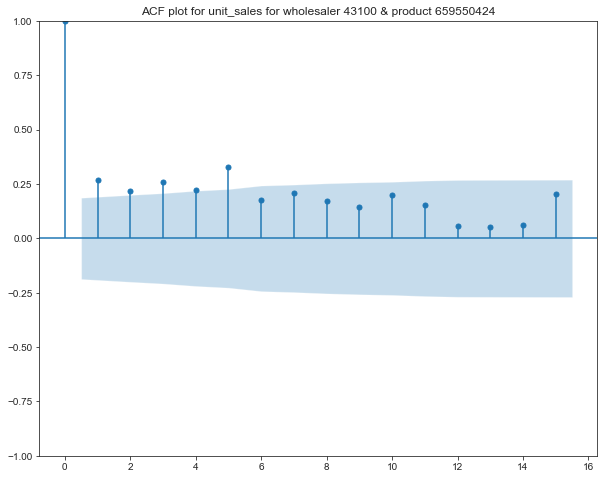

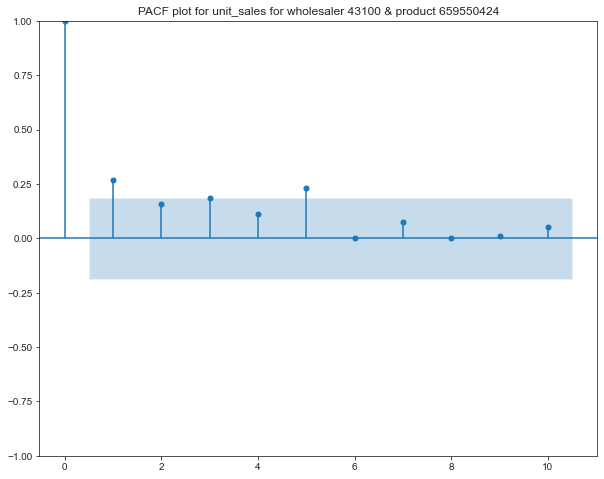

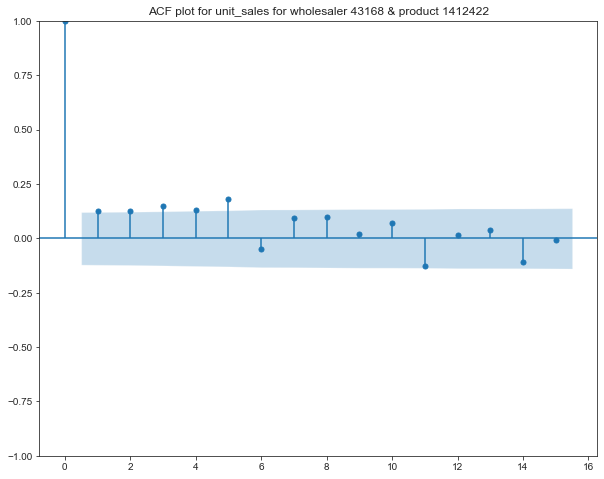

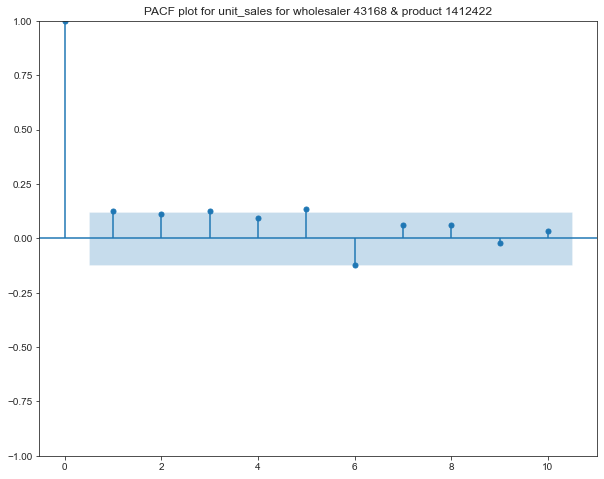

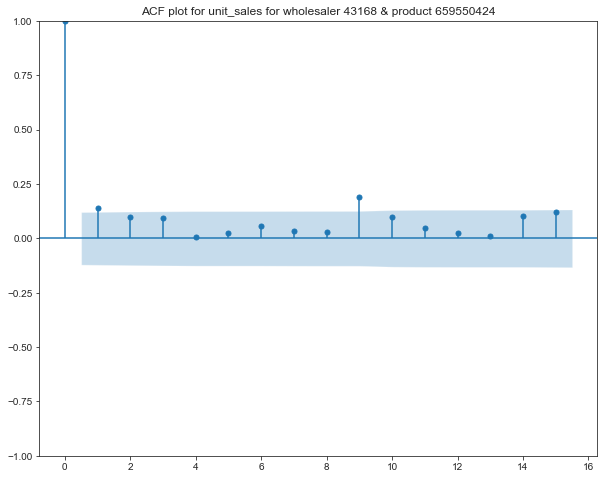

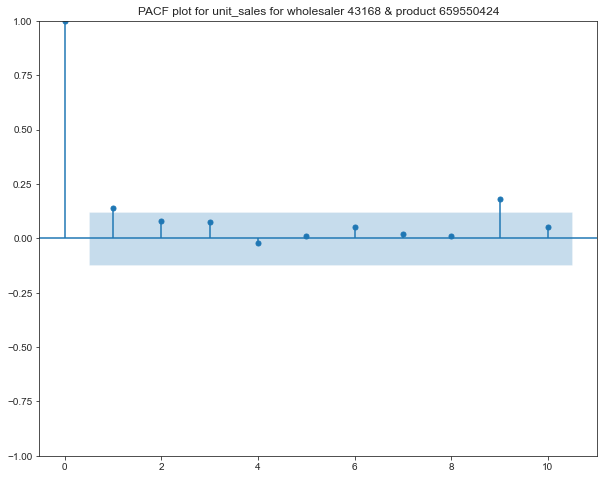

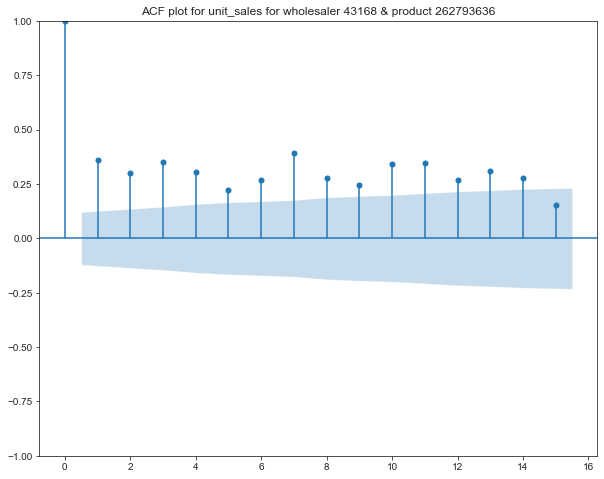

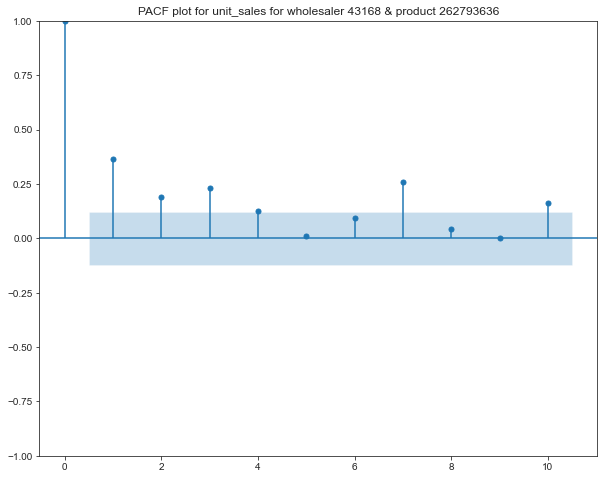

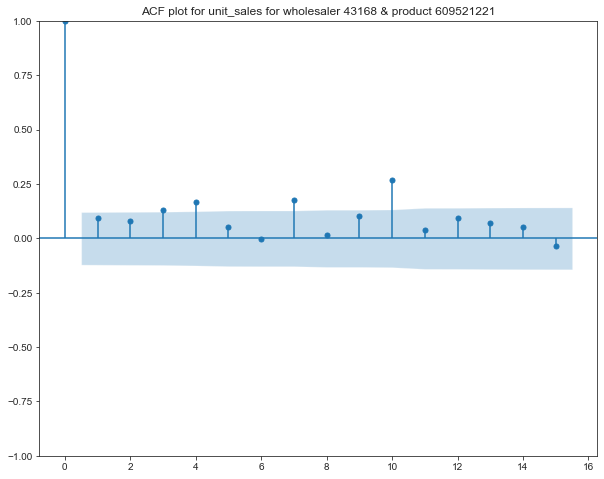

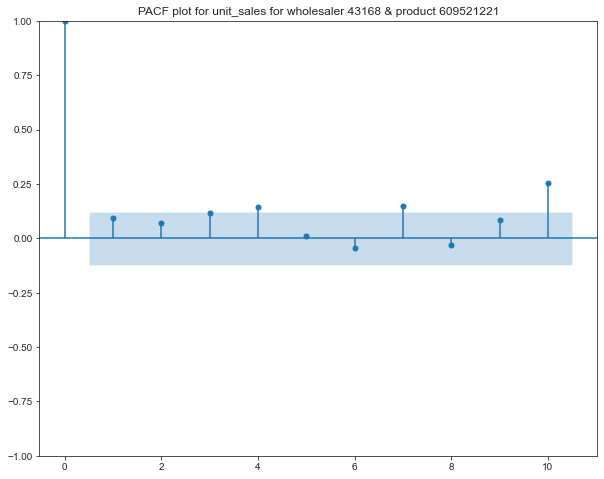

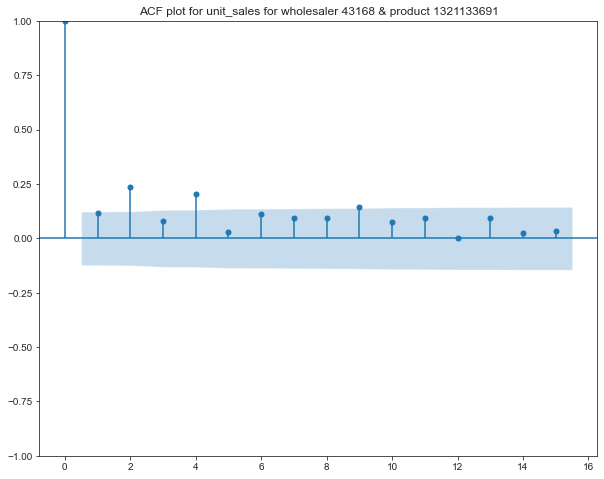

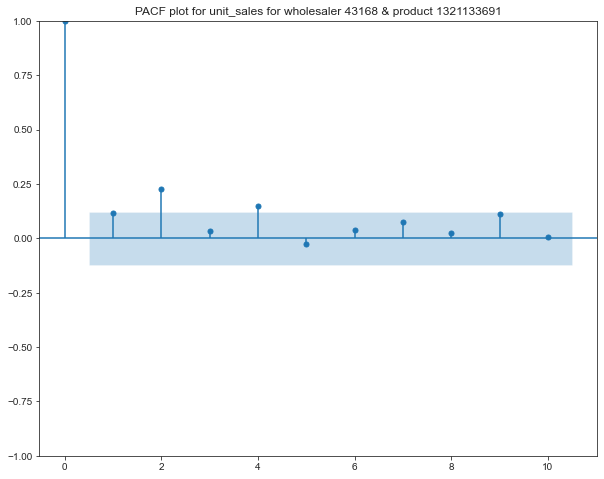

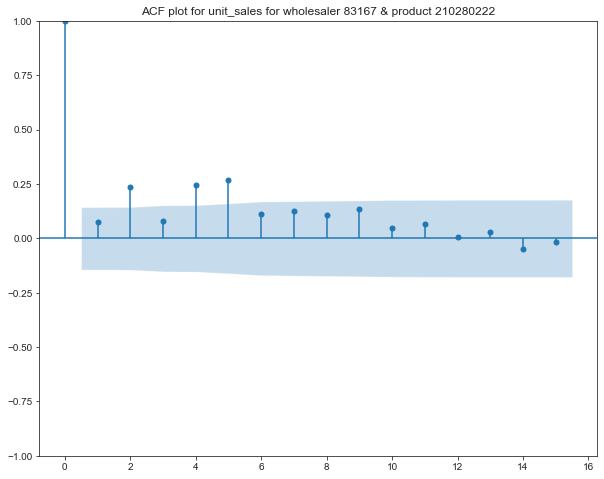

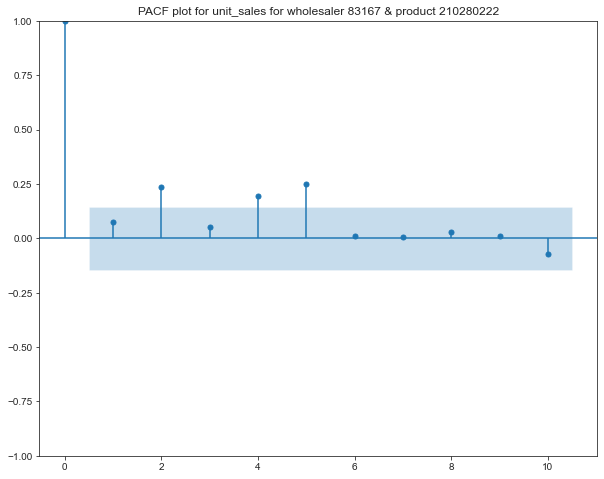

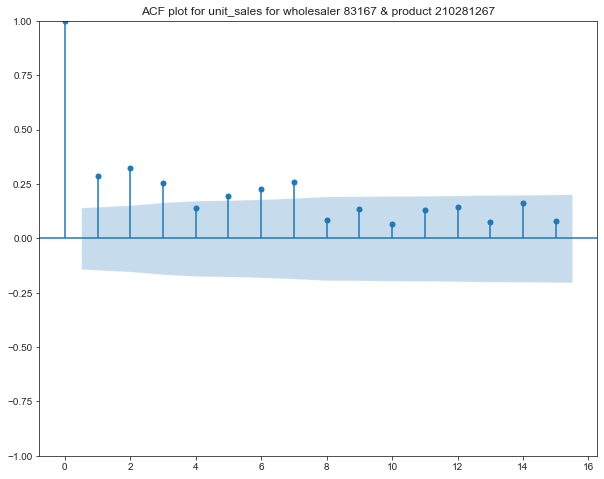

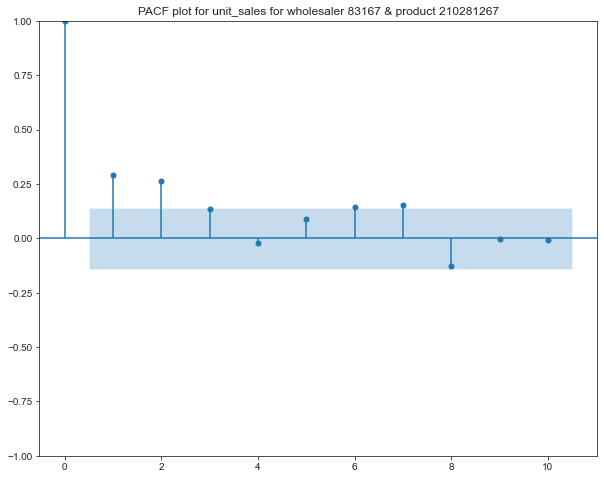

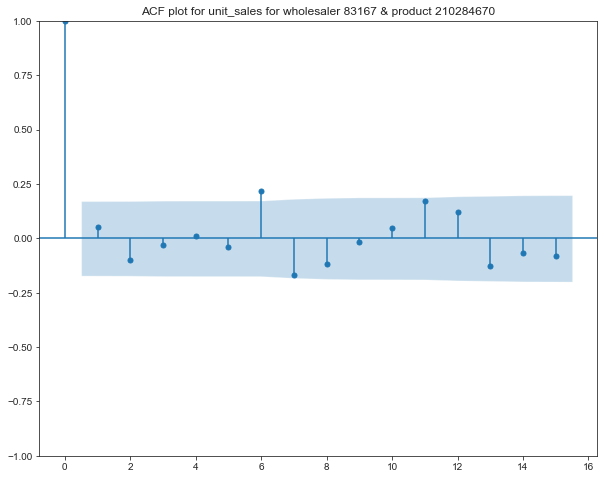

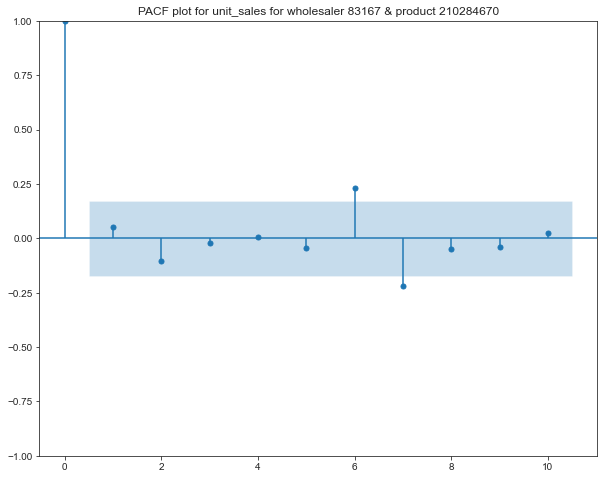

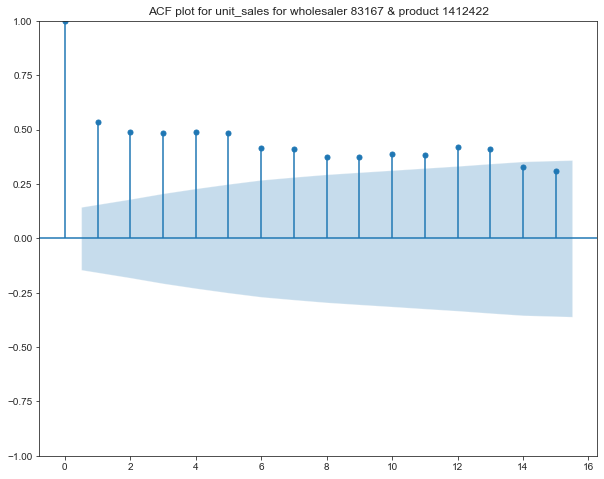

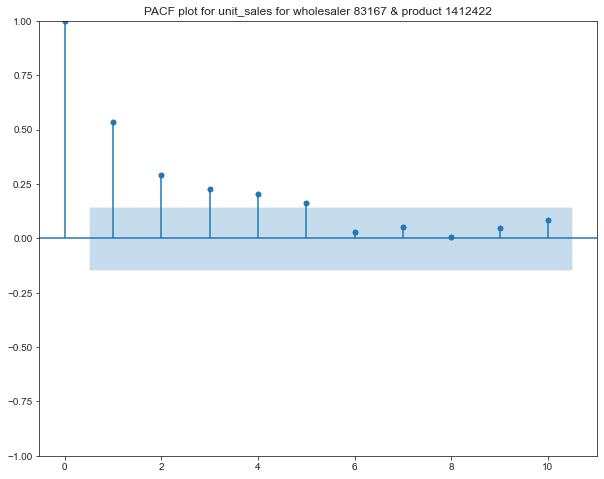

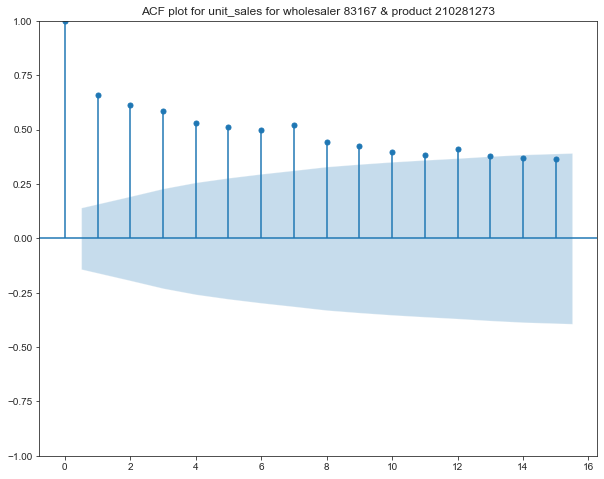

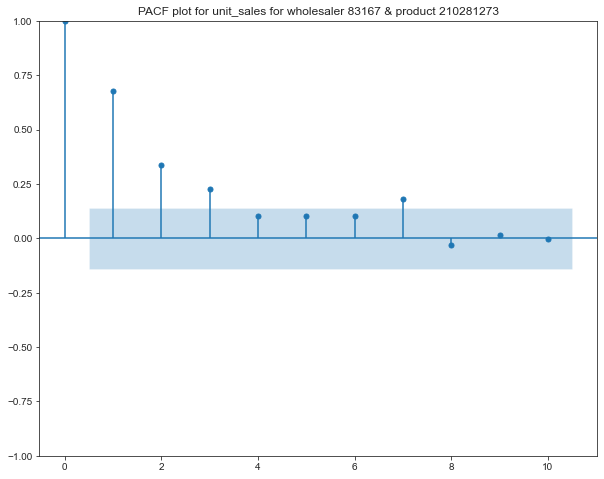

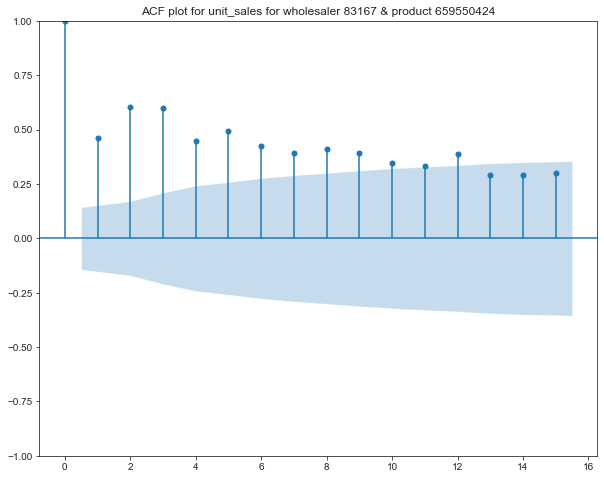

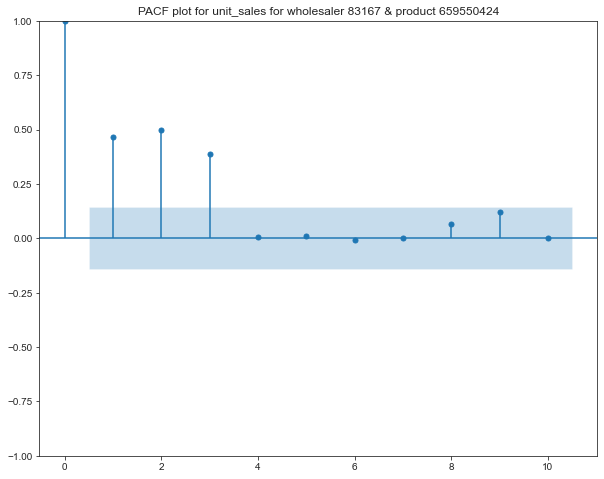

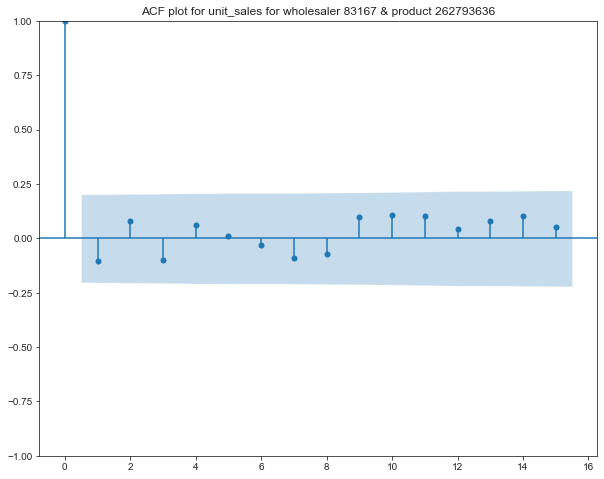

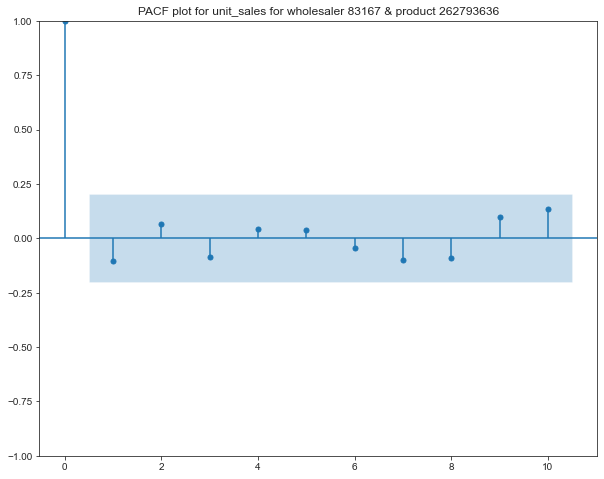

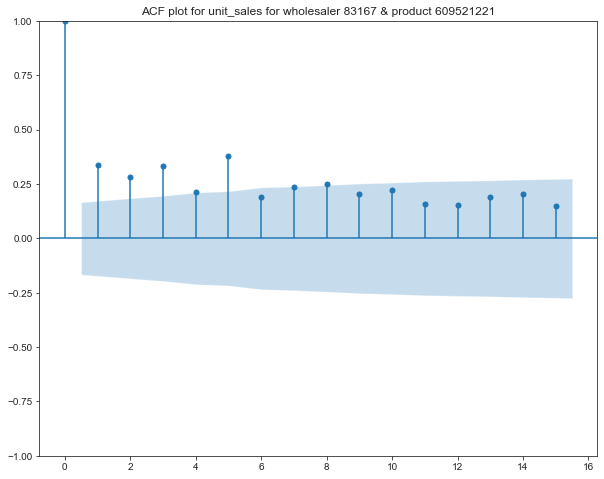

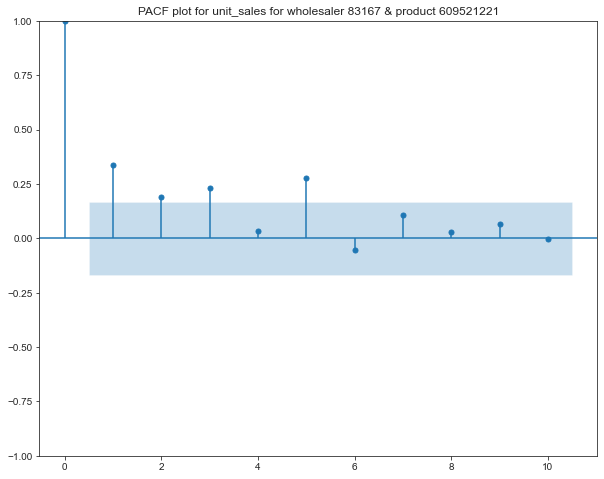

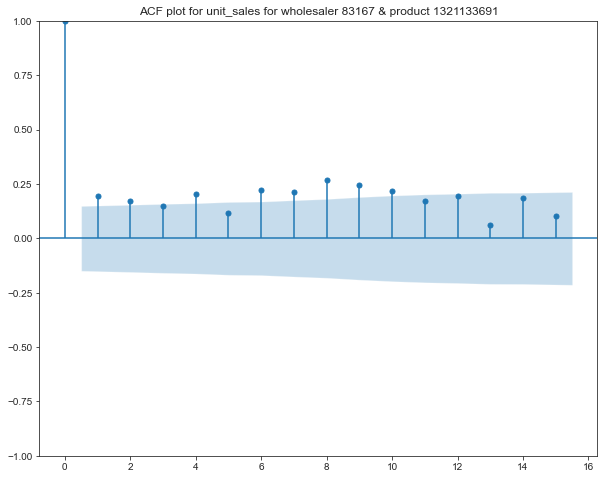

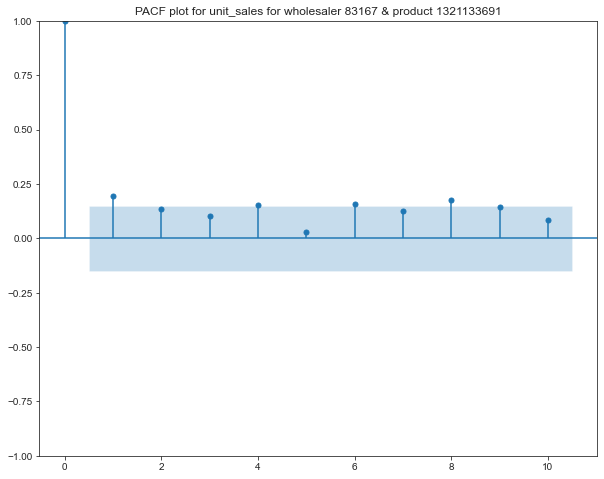

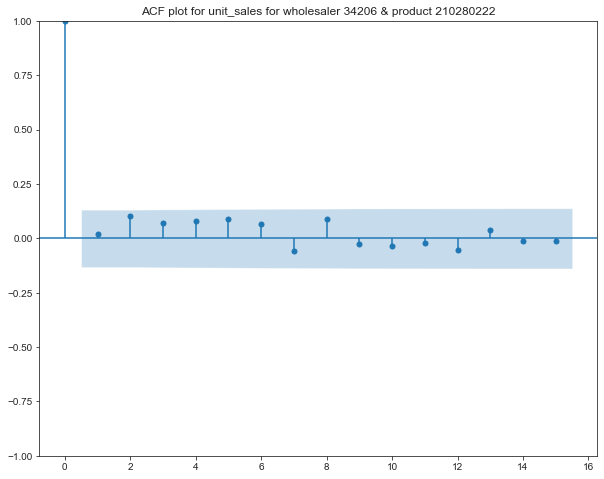

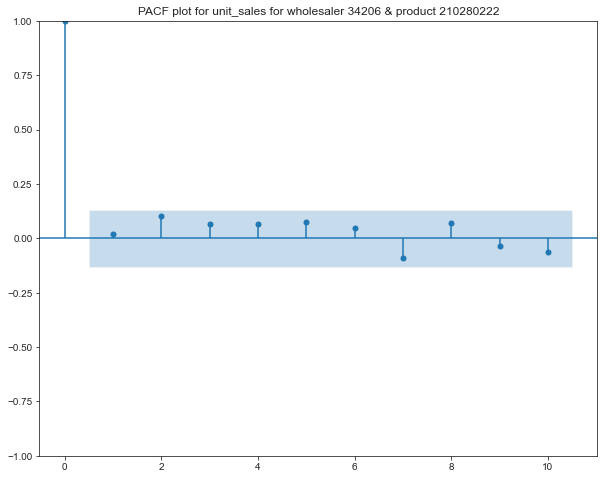

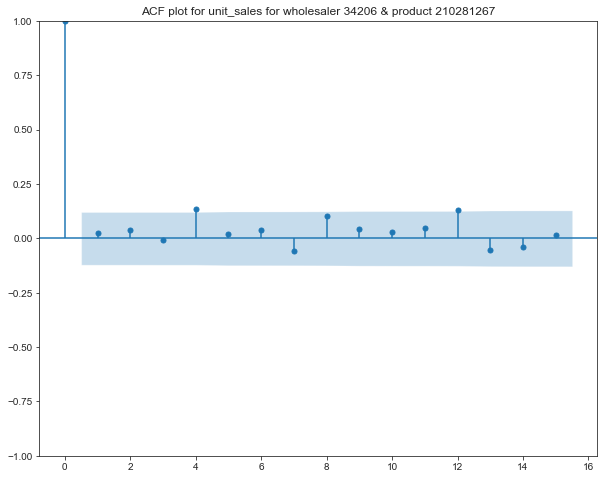

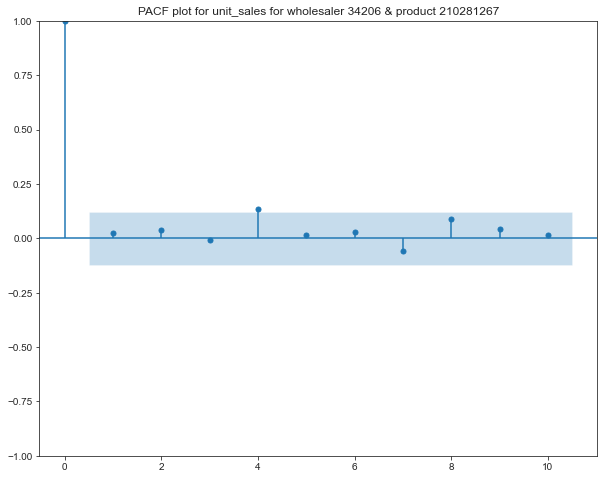

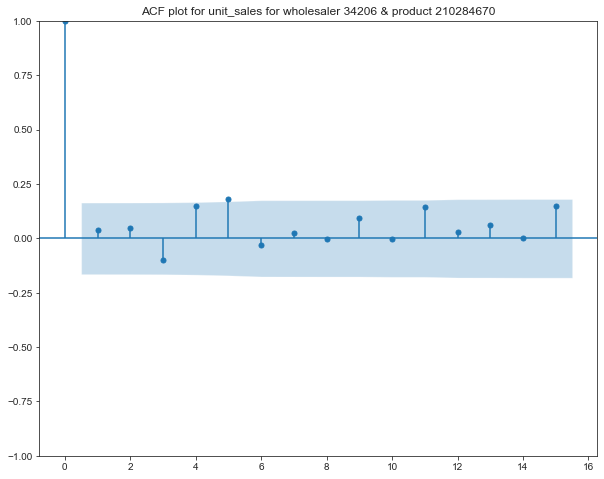

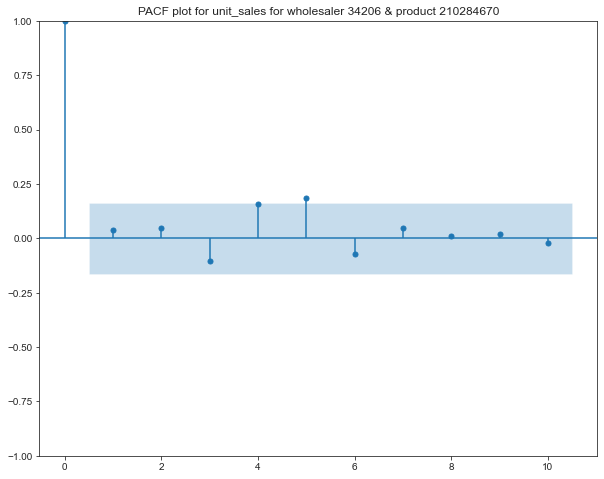

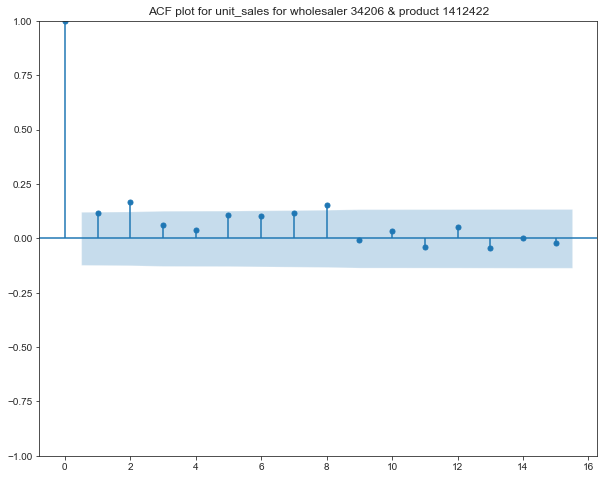

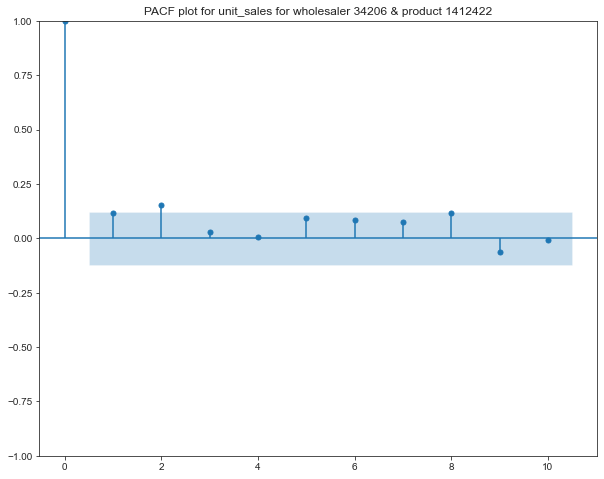

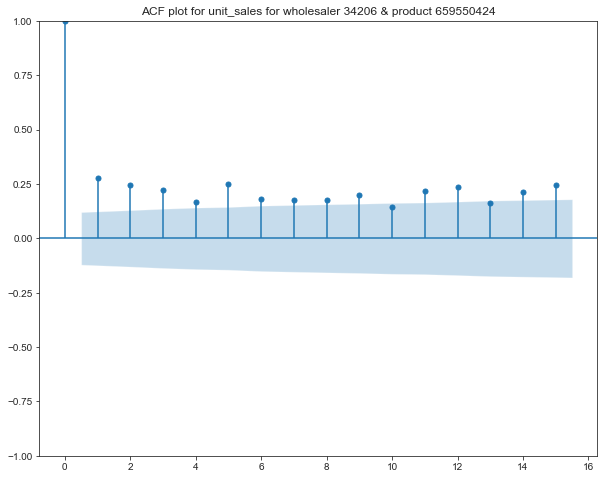

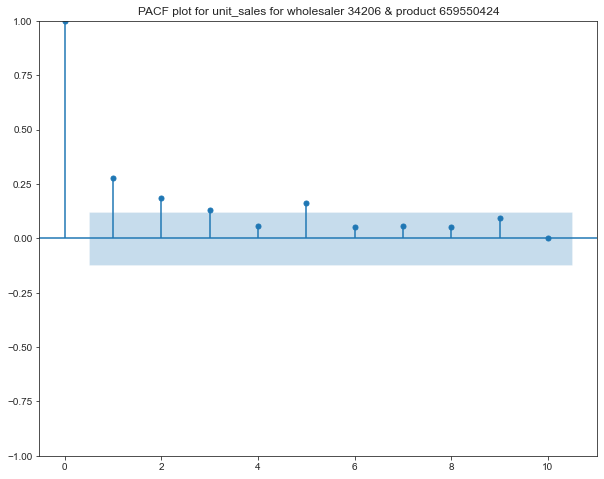

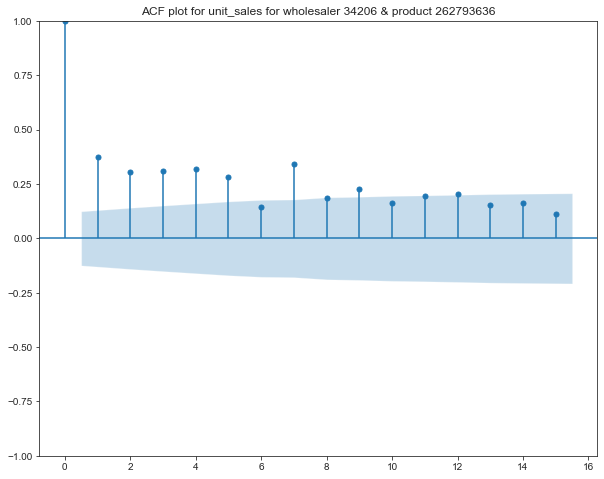

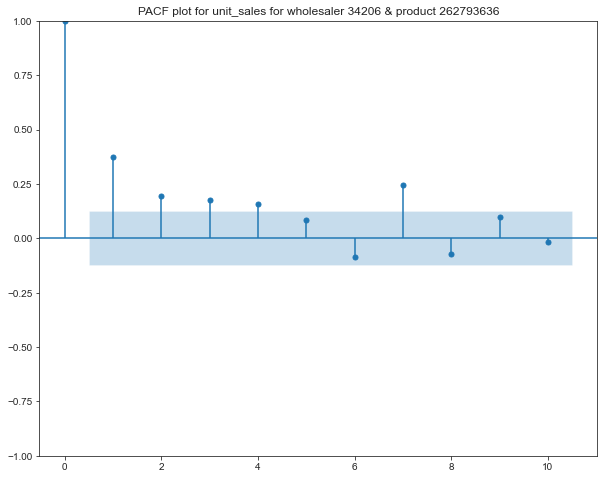

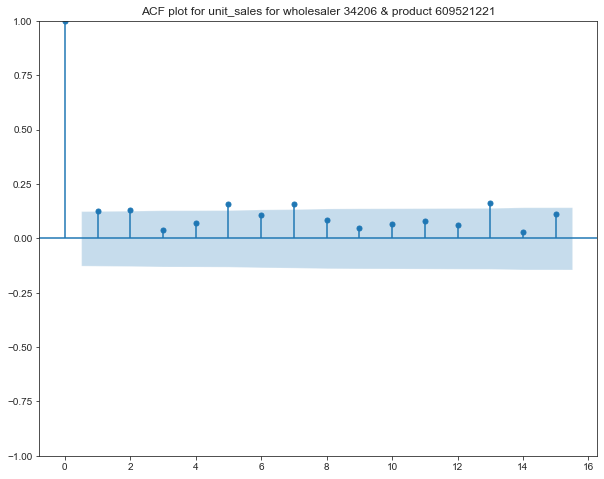

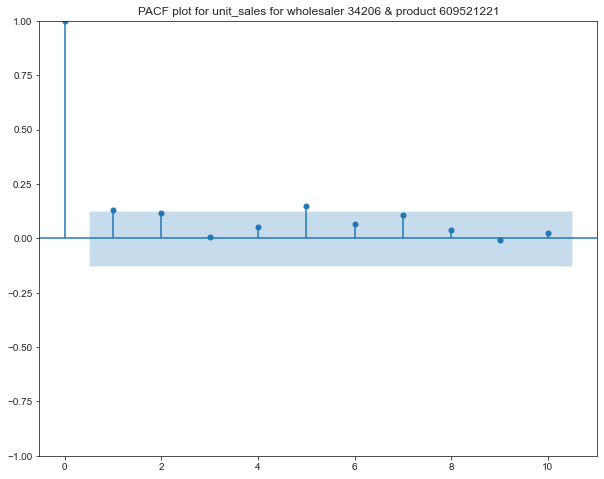

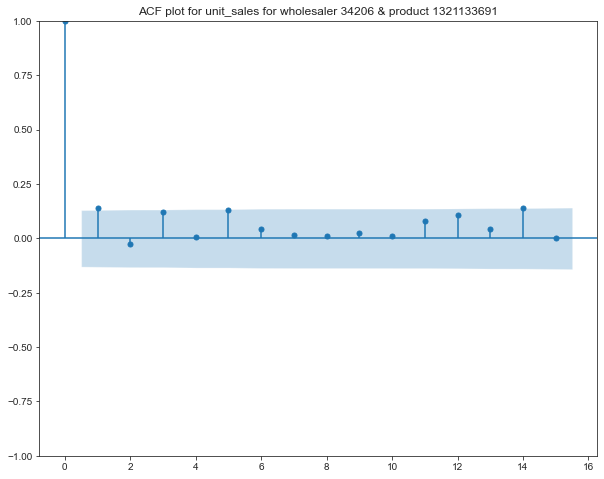

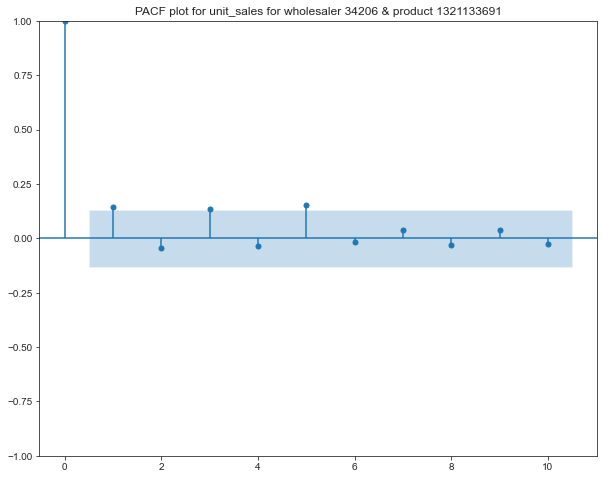

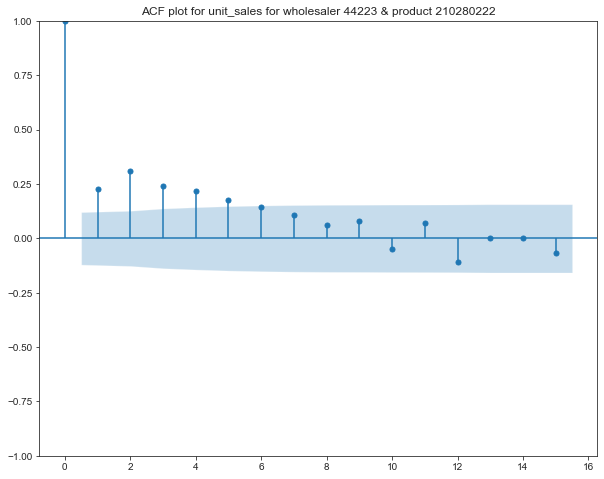

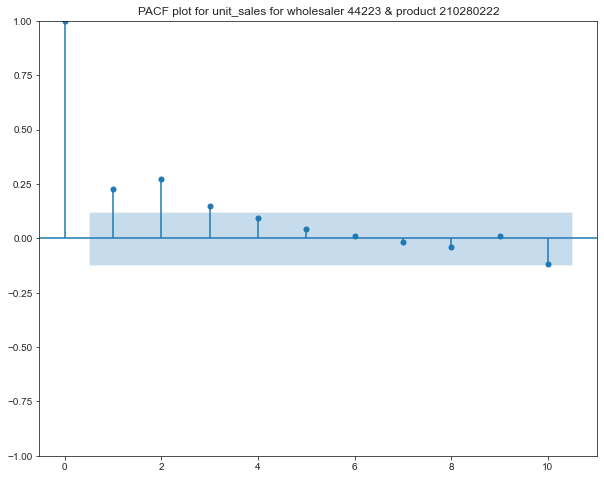

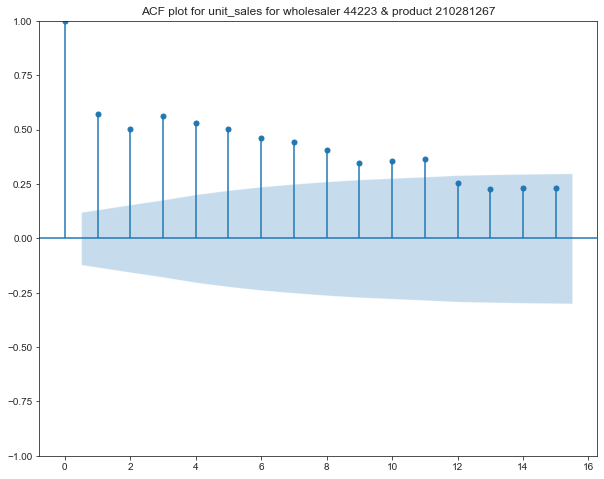

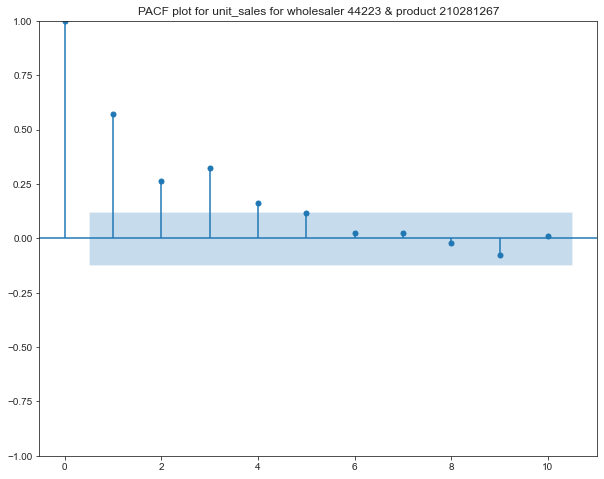

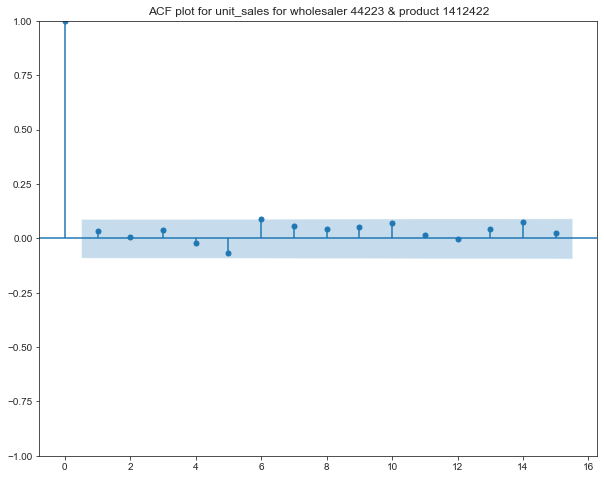

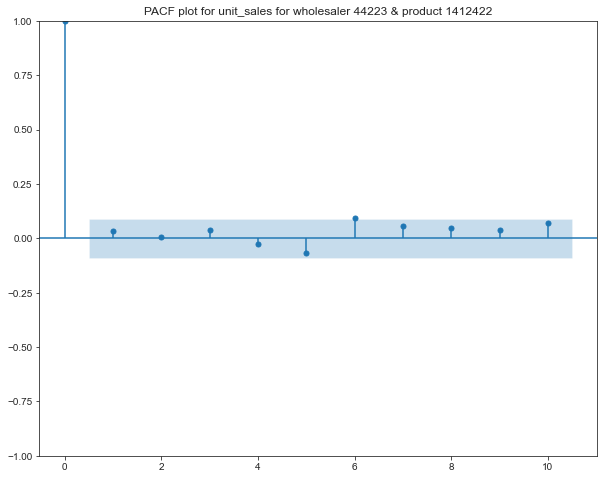

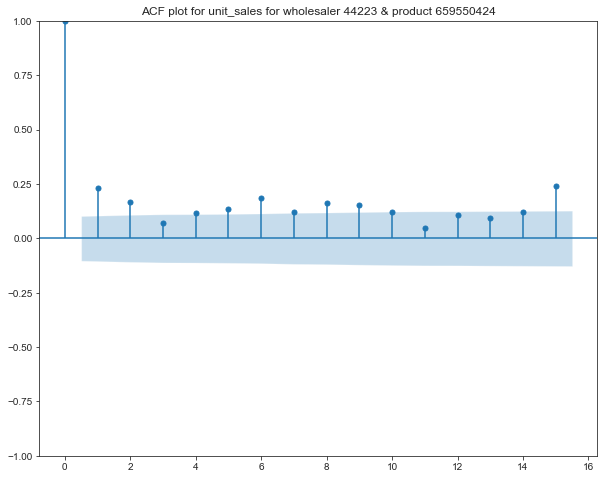

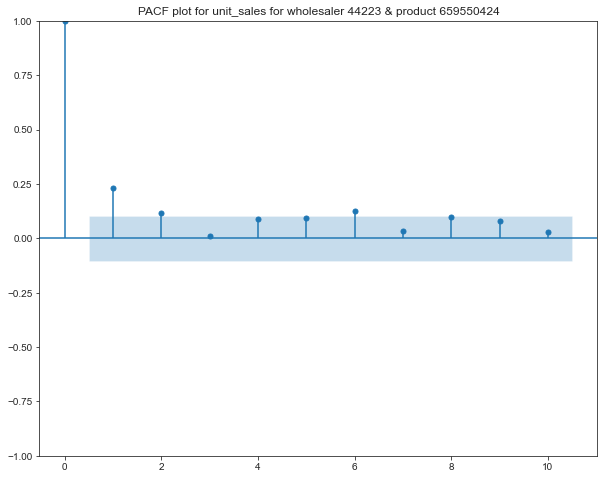

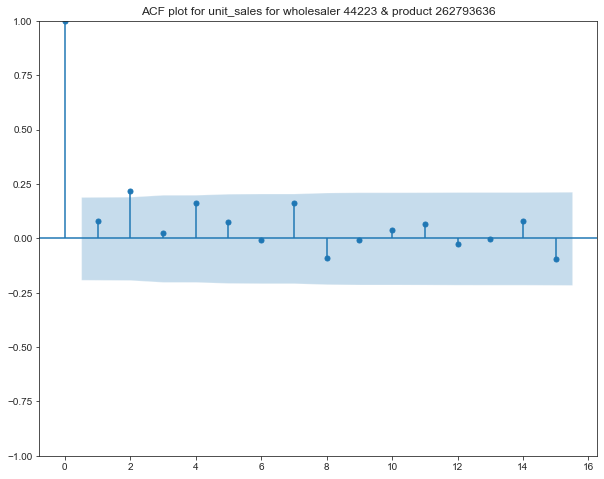

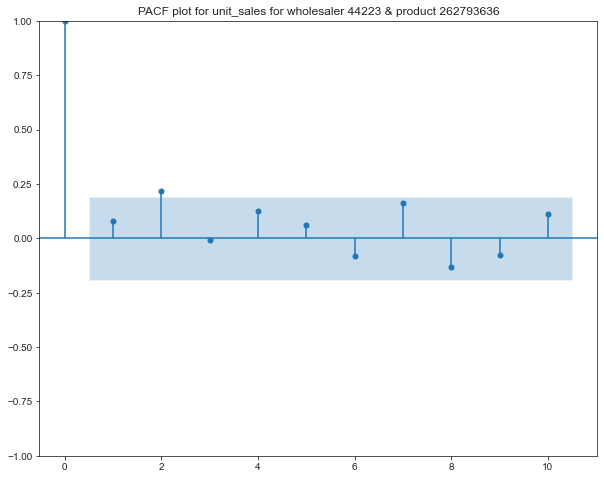

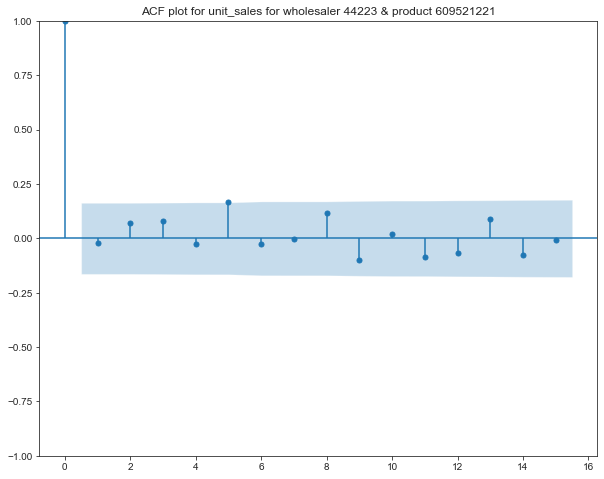

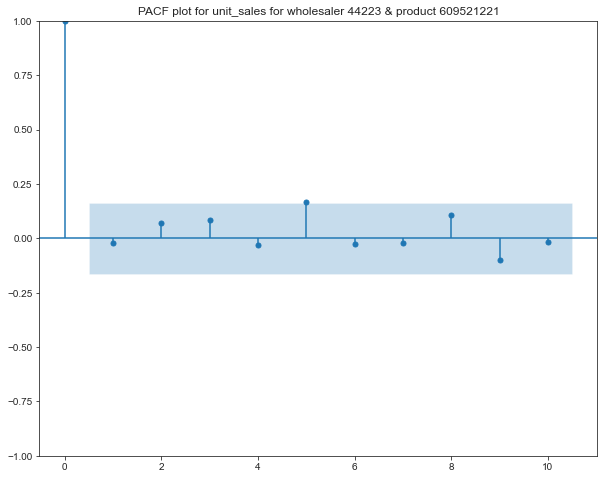

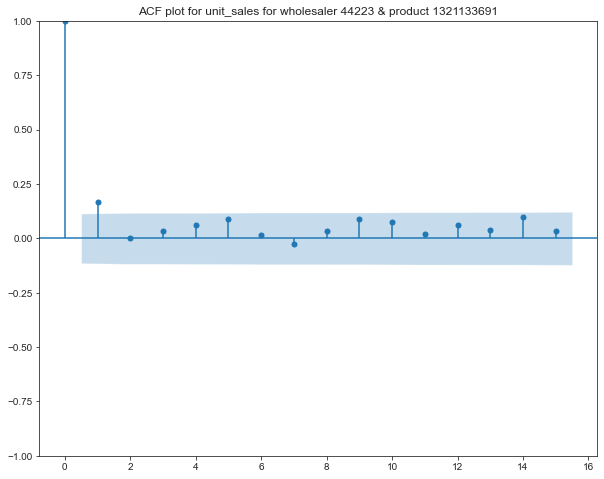

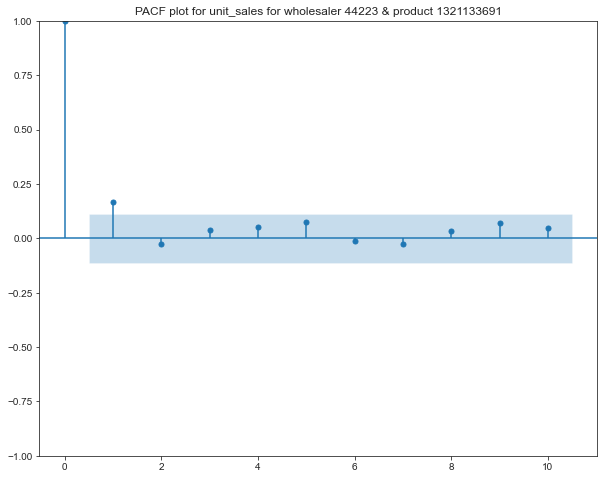

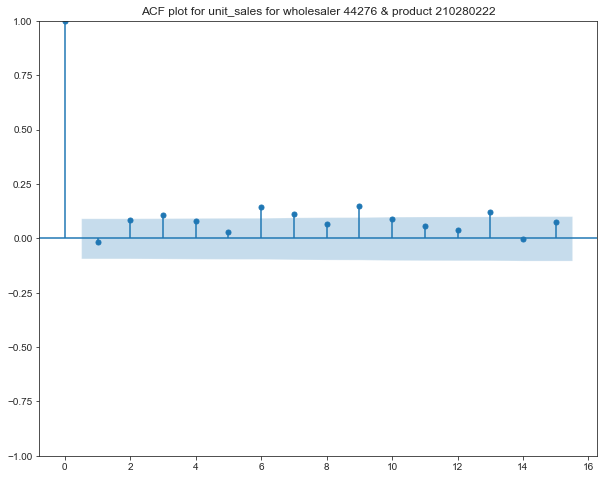

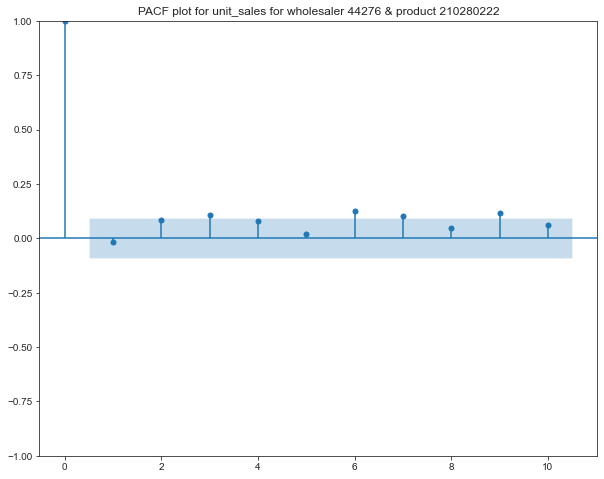

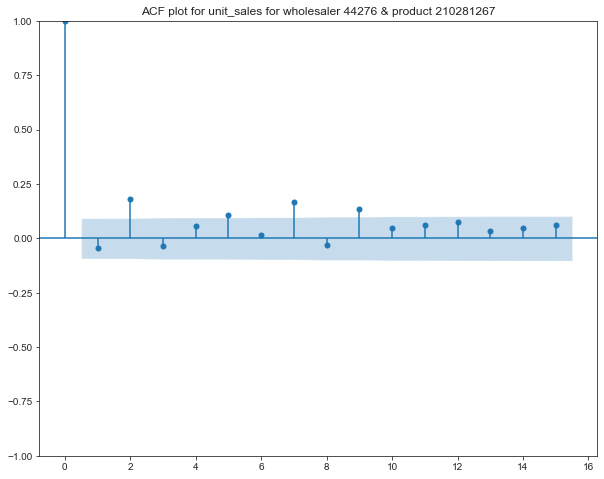

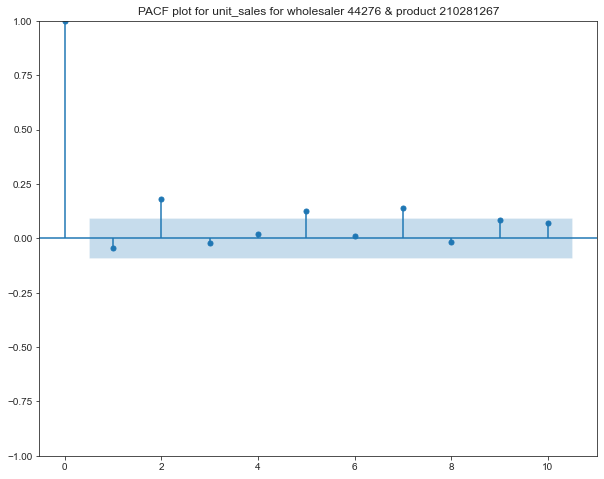

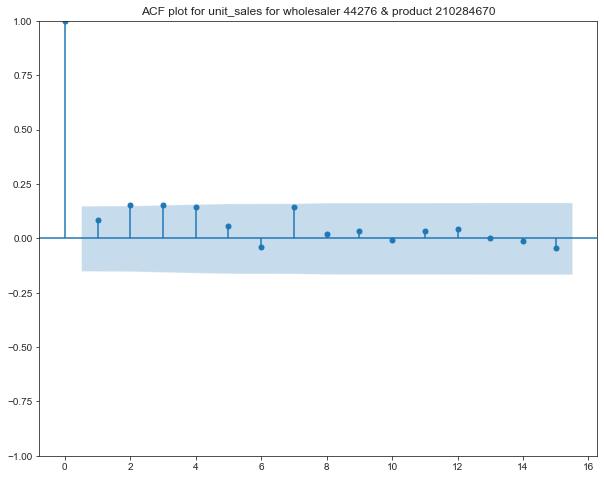

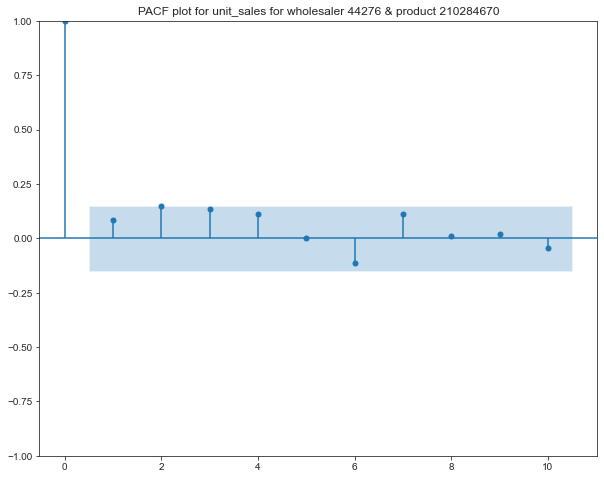

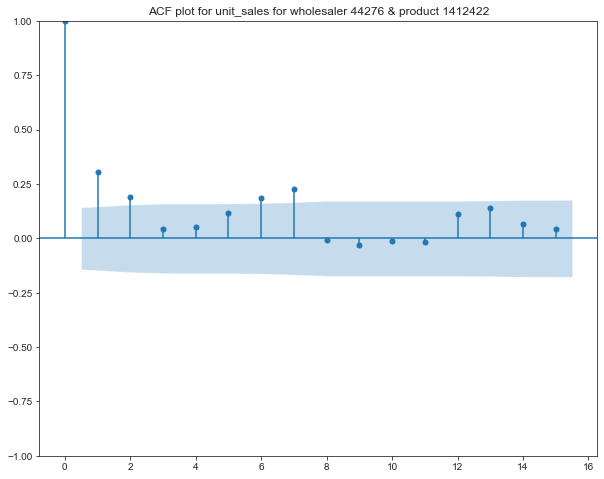

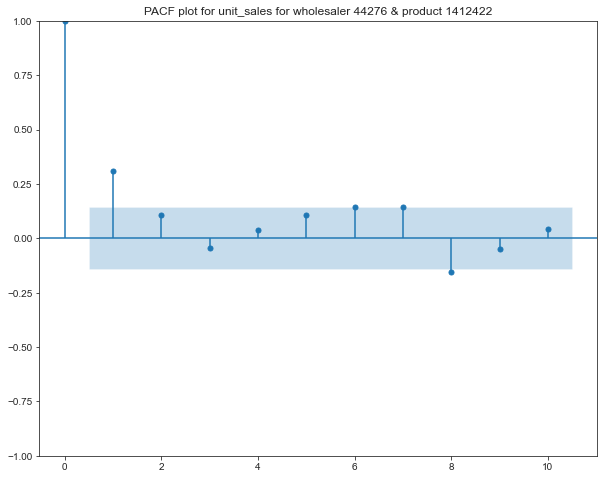

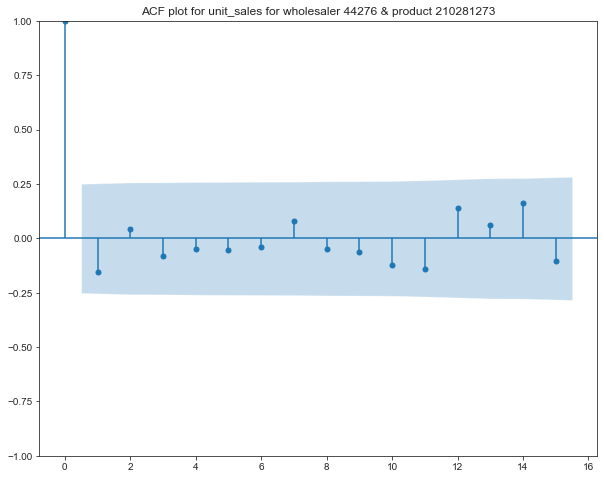

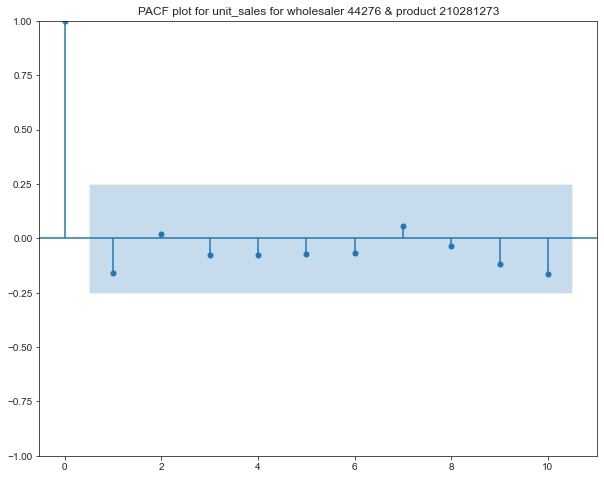

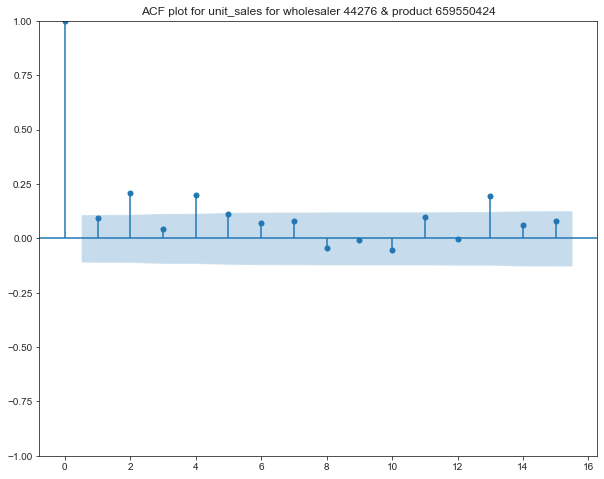

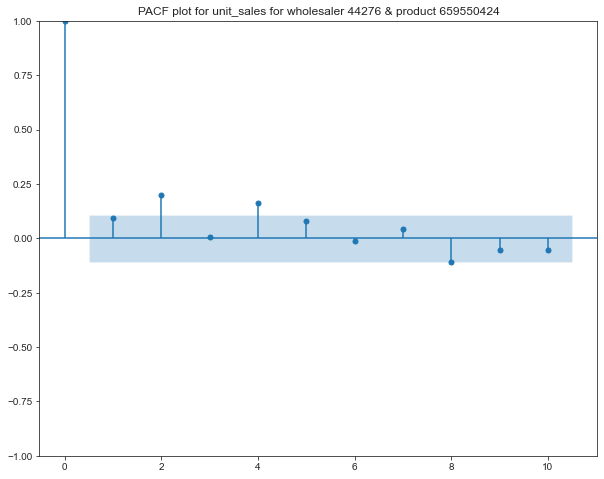

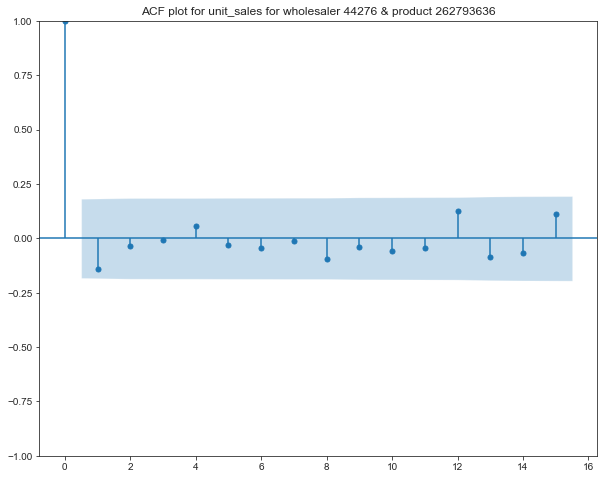

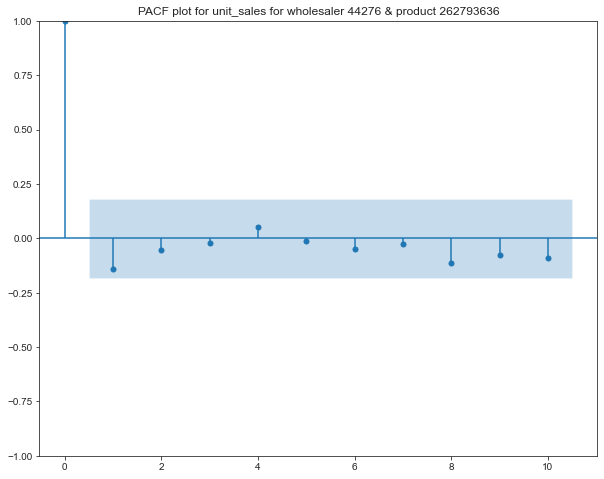

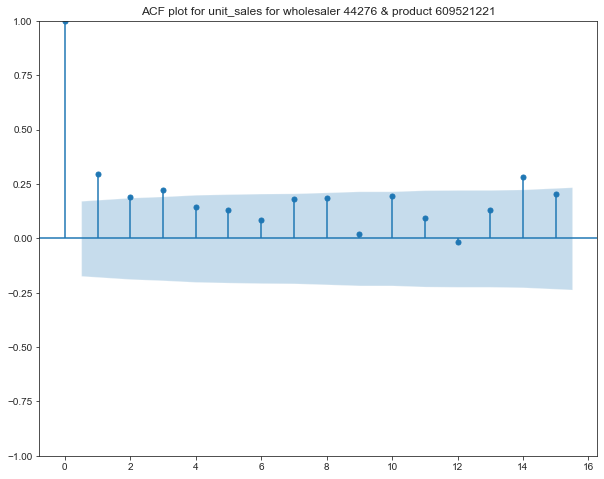

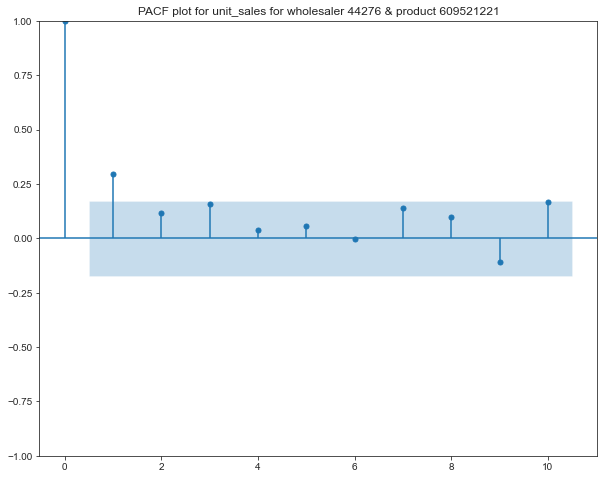

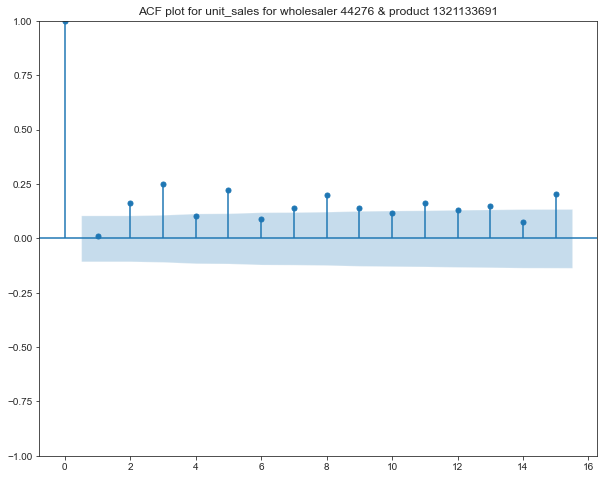

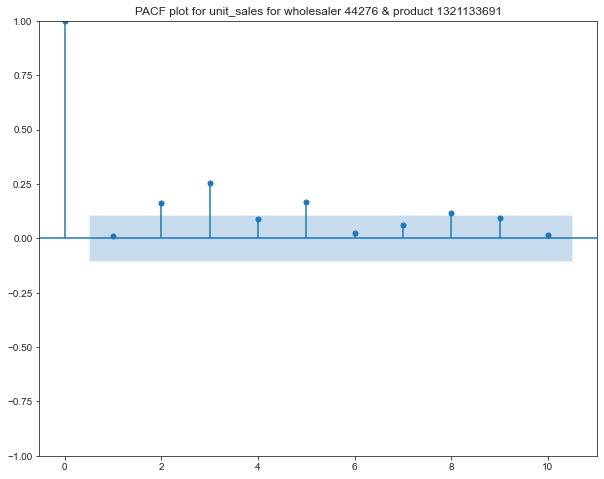

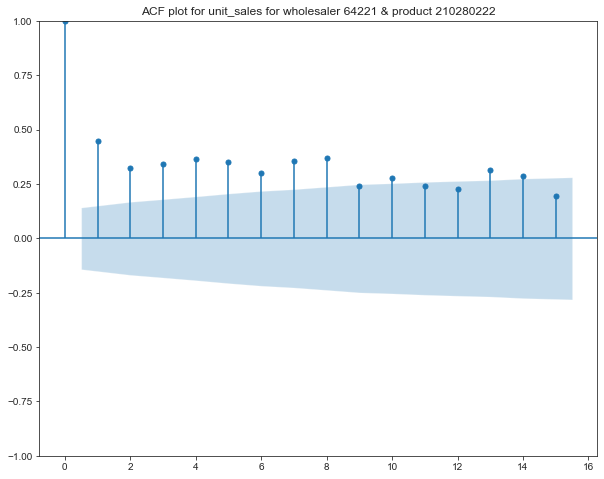

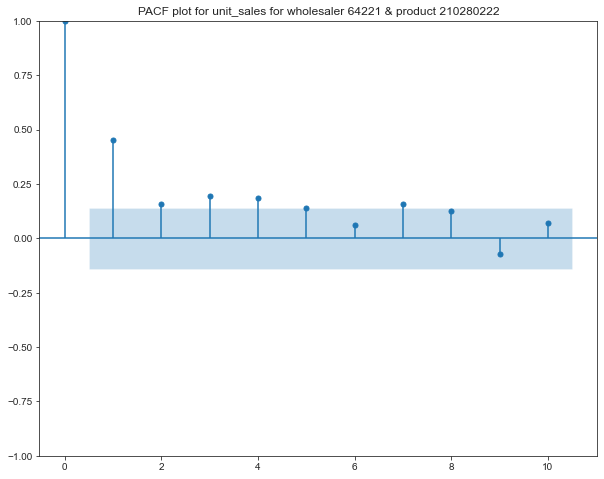

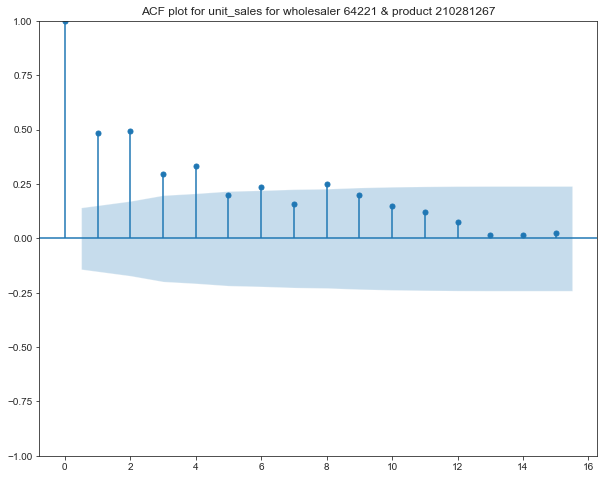

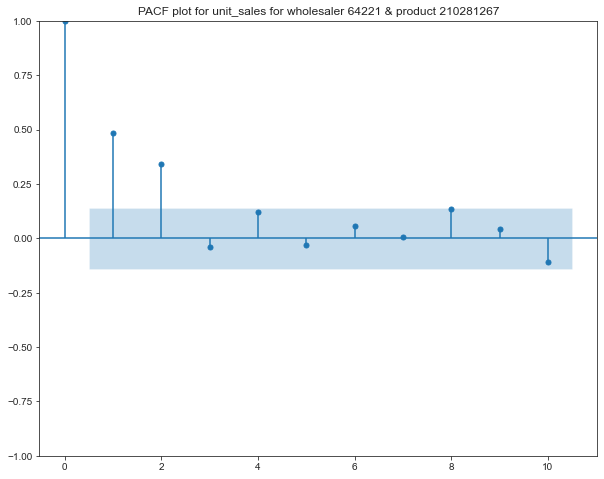

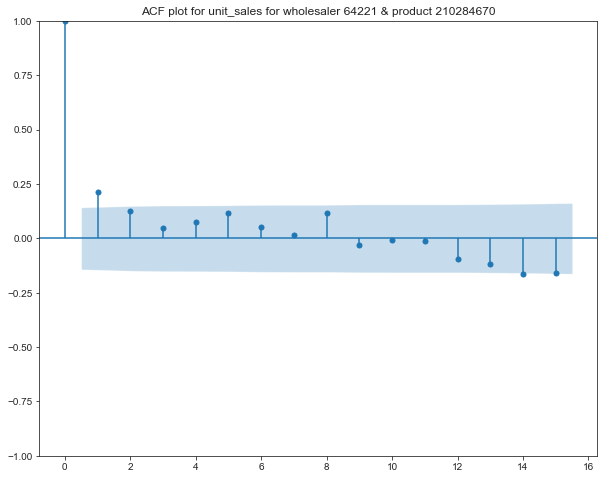

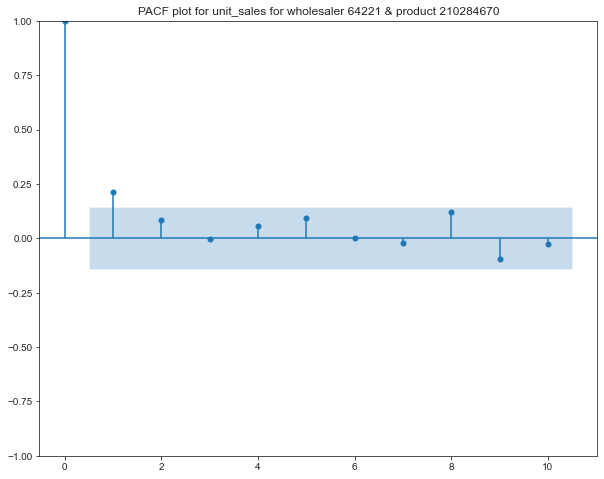

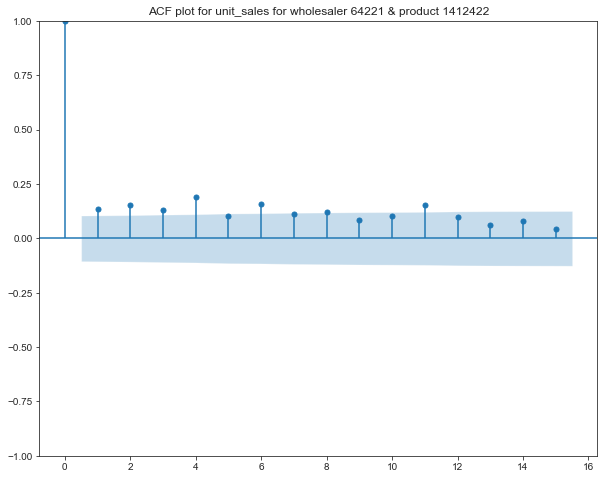

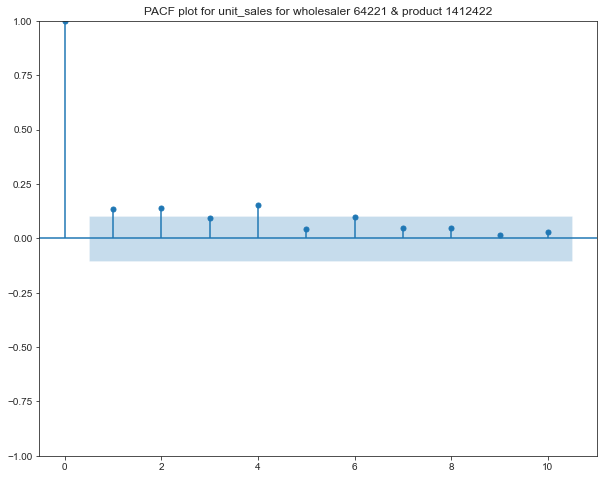

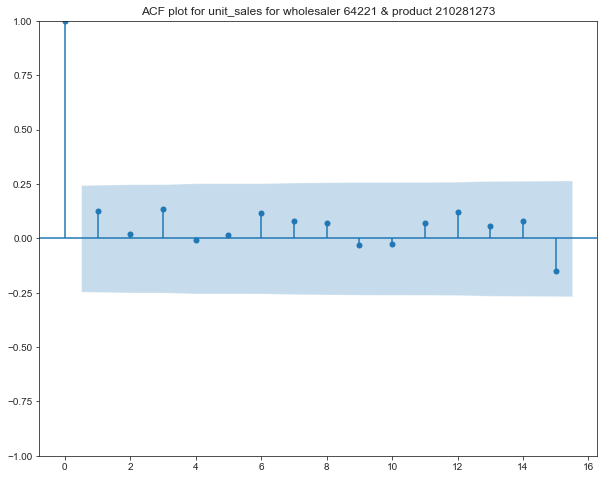

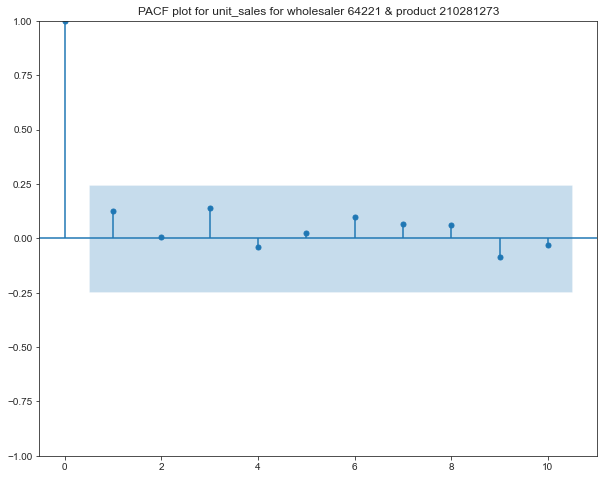

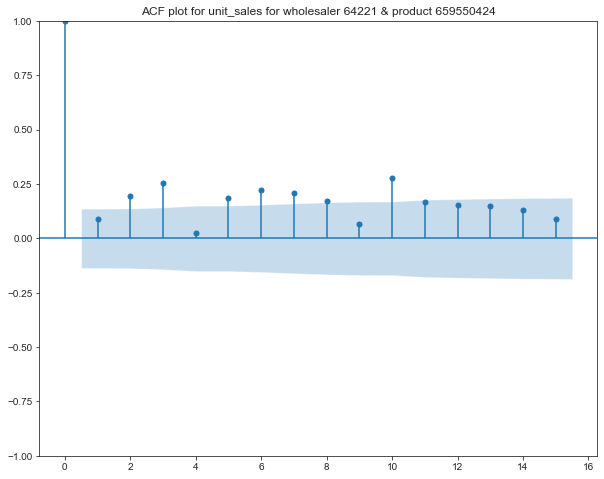

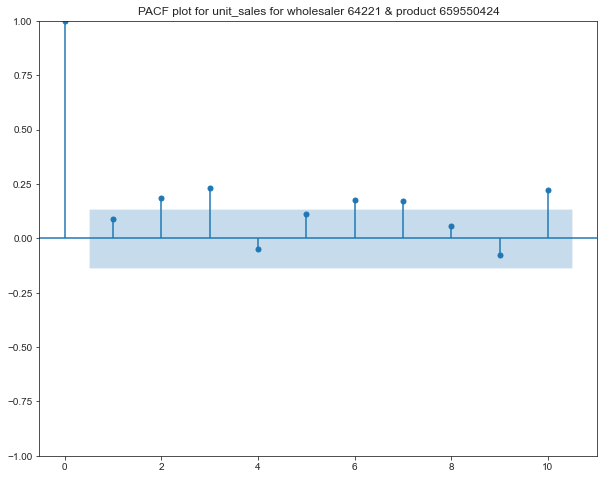

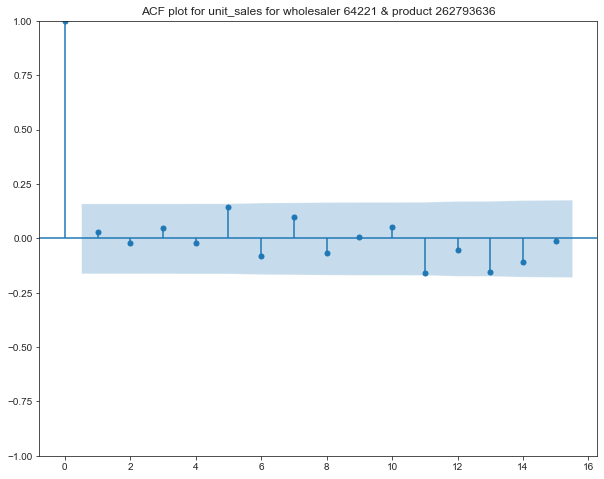

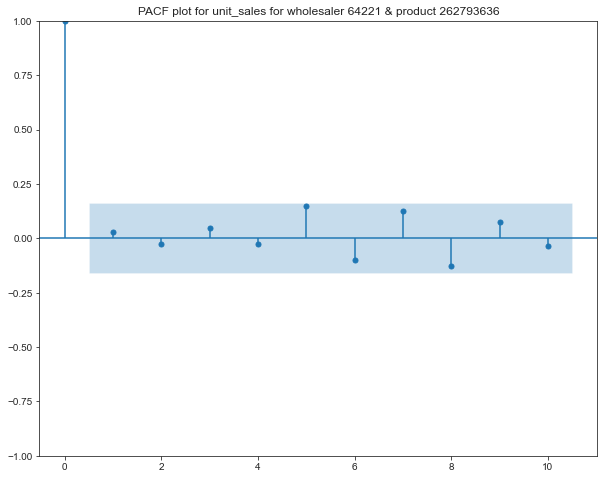

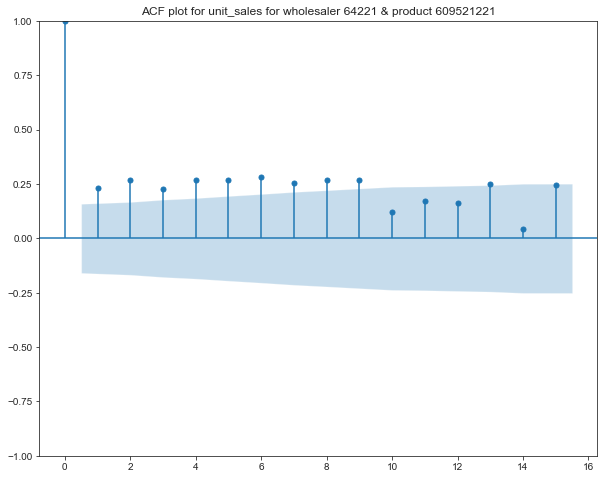

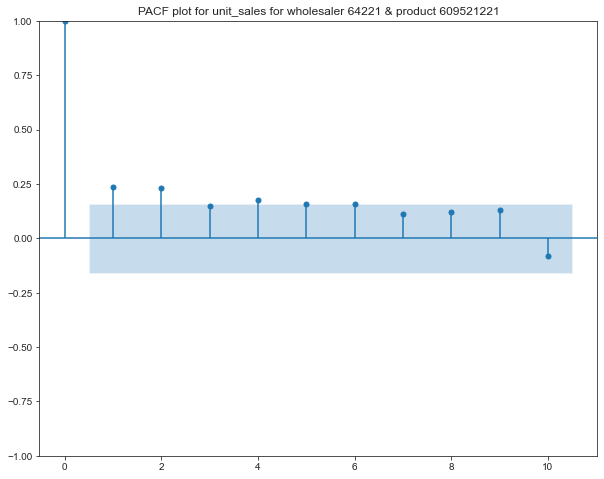

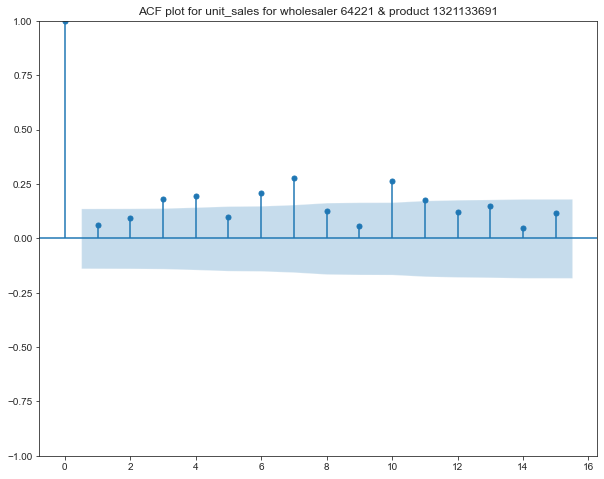

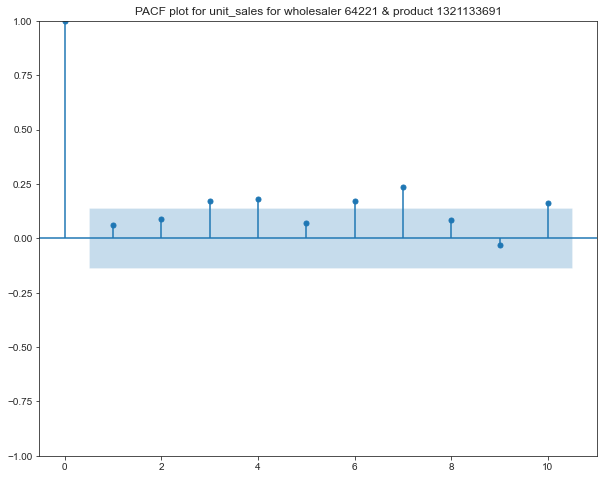

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


for w in unique_wholesalers:
    for p in unique_products:
        if (w, p) not in no_sales_list:
            
            df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
            plot_acf(df_small['unit_sales'], lags=15)
            plt.title(f'ACF plot for unit_sales for wholesaler {w} & product {p}')

            plot_pacf(df_small['unit_sales'], lags=10, method='ols')
            plt.title(f'PACF plot for unit_sales for wholesaler {w} & product {p}')

- **`There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random and is not white noise.`** <br>
- **`For most of the time series, high degree of autocorrelation between adjacent (lag = 2) and near-adjacent (lag = 3) observations in PACF plot`**
- **`High degree of autocorrelation between several adjacent lag observations in ACF plot.`**

## Feature Engineering - at each time series level

### Considering the autocorrelations based on ACF  & PACF plots - Create lagged features

In [87]:
def get_lagged_features(df, col):
    
    df_lagged = df.copy()
      
    df_lagged[f'{col}_lag_2'] = df_lagged[col].shift(2)
    df_lagged[f'{col}_lag_5'] = df_lagged[col].shift(3)    

    df_lagged = df_lagged.fillna(method='bfill')
    
    return df_lagged

df_lagged_list = []
for w in unique_wholesalers:
    for p in unique_products:
        if (w, p) not in no_sales_list:
            
            df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
            df_lagged_list.append(get_lagged_features(df_small, 'unit_sales'))
            
            
df_lagged = pd.concat(df_lagged_list)
df_lagged.shape

(16260, 28)

### Create rolling window features

In [88]:
def get_rolling_window_features(df, col):
    
    df_rolling_window = df.copy()
      
    df_rolling_window[f'{col}_rolling_mean'] = df_rolling_window[col].rolling(window=8).mean()
    df_rolling_window = df_rolling_window.fillna(method='bfill')
    
    return df_rolling_window

df_rolling_window_list = []
for w in unique_wholesalers:
    for p in unique_products:
        if (w, p) not in no_sales_list:
            
            df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
            df_rolling_window_list.append(get_rolling_window_features(df_small, 'unit_sales'))
            
            
df_rolling_window = pd.concat(df_rolling_window_list)
df_rolling_window.shape

(16260, 27)

In [89]:
df_rolling_window.head()

,dates,geography_key,wholesaler_id_value,state_code,city,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday,product_price,relative_beer_style_price,Era,brewer,unit_sales_rolling_mean
0,2018-12-23,39774,3142,NY,JAMESTOWN,RITE AID - RITE AID PHARMACY,DRUG,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,15.00,29.85,1.30,2018,12,23,51,winter,0,1.99,0.98,Pre Covid,AB,24.12
3,2018-12-23,627036,3142,NY,JAMESTOWN,7-ELEVEN - 7 ELEVEN/NORTH ATLANTIC DIV,CONVENIENCE,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,35.00,71.21,3.00,2018,12,23,51,winter,0,2.03,1.00,Pre Covid,AB,24.12
62,2020-01-05,39774,3142,NY,JAMESTOWN,RITE AID - RITE AID PHARMACY,DRUG,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,6.00,12.00,0.52,2020,1,5,1,winter,1,2.00,0.98,Covid,AB,24.12
64,2020-01-05,627036,3142,NY,JAMESTOWN,7-ELEVEN - 7 ELEVEN/NORTH ATLANTIC DIV,CONVENIENCE,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,31.00,68.91,2.69,2020,1,5,1,winter,1,2.22,1.09,Covid,AB,24.12
103,2019-10-20,39774,3142,NY,JAMESTOWN,RITE AID - RITE AID PHARMACY,DRUG,210280222,CLASSIC LAGER,CORE,AMERICAN LAGER,ANHEUSER-BUSCH INBEV,BEER,6.00,12.38,0.50,2019,10,20,42,summer,1,2.06,1.01,Pre Covid,AB,24.12


## Save the final datasets

In [90]:
df.to_csv('data/df_final.csv', index=False)
df_filled_missing.to_csv('data/df_filled_missing.csv', index=False)
df_lagged.to_csv('data/df_lagged.csv', index=False)
df_rolling_window.to_csv('data/df_rolling_window.csv', index=False)